# Análisis de Datos
## TP N 1
----
### Grupo N° 7
- Aviani, José
- Díaz, José Luis
- Silvera, Ricardo

---
## Introducción

Para este trabajo elegimos el el dataset Precios Claros – Base SEPA, perteneciente al “Sistema Electrónico de Publicidad de Precios Argentinos (SEPA)" (https://datos.gob.ar/), el cual reúne los precios de comercios minoristas (grandes establecimientos) de más de 70 mil productos en toda la Argentina. Particularmente para este trabajo, seleccionamos el set de datos del establecimiento **Carrefour** ya que era el de mayor tamaño, lo cual es deseable como entrada en un problema de aprendizaje de máquina.
A continuación realizamos el análisis exploratorio de los datos y finalizamos con las conclusiones obtenidas del trabajo.


### Importación de librerías

In [596]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import missingno as msno
import scipy.stats as ss
from scipy.stats import kurtosis

## Análisis Exploratorio de los Datos

### Carga y comprensión de los datos


Los datos están separados en 3 archivos
- comercio
- sucursales
- productos

Cada uno contiene información específica sobre la entidad que indica su nombre. Vamos a investigar a cada uno para comprender la información que contienen y como está organizada y unificar todos los datos que nos interesen en un único dataframe. 

In [597]:
#Comercio
comercio=pd.read_csv('./dataset/comercio.csv',delimiter='|')
#Sucursales
sucursales=pd.read_csv('./dataset/sucursales.csv',delimiter='|')
#Productos
productos=pd.read_csv('./dataset/productos.csv.gz', delimiter='|', compression='gzip', low_memory=False)

# La ultima linea del achivo es solamente la fecha de actualizacion, por eso la borramos
comercio = comercio.iloc[:-1]
sucursales = sucursales.iloc[:-1]
productos = productos.iloc[:-1]


In [598]:
print(comercio.shape)
print(comercio.info())
print(comercio.head(25))

(3, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id_comercio                    3 non-null      object 
 1   id_bandera                     3 non-null      float64
 2   comercio_cuit                  3 non-null      float64
 3   comercio_razon_social          3 non-null      object 
 4   comercio_bandera_nombre        3 non-null      object 
 5   comercio_bandera_url           3 non-null      object 
 6   comercio_ultima_actualizacion  3 non-null      object 
 7   comercio_version_sepa          3 non-null      float64
dtypes: float64(3), object(5)
memory usage: 324.0+ bytes
None
  id_comercio  id_bandera  comercio_cuit comercio_razon_social  \
0          10         1.0   3.068731e+10              INC S.A.   
1          10         3.0   3.068731e+10              INC S.A.   
2          10         2.0   3.068

In [599]:
print(sucursales.shape)
print(sucursales.info())

(563, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_comercio                            563 non-null    object 
 1   id_bandera                             563 non-null    float64
 2   id_sucursal                            563 non-null    float64
 3   sucursales_nombre                      563 non-null    object 
 4   sucursales_tipo                        563 non-null    object 
 5   sucursales_calle                       563 non-null    object 
 6   sucursales_numero                      559 non-null    float64
 7   sucursales_latitud                     563 non-null    float64
 8   sucursales_longitud                    563 non-null    float64
 9   sucursales_observaciones               17 non-null     object 
 10  sucursales_barrio                      302 non-null    object 
 

In [600]:
print(sucursales.head(25))

   id_comercio  id_bandera  id_sucursal              sucursales_nombre  \
0           10         3.0        365.0                     Nazca 1944   
1           10         3.0        408.0                       Perú 916   
2           10         2.0        144.0                    La Plata II   
3           10         3.0        755.0  C.Tribulato 1279 (San Miguel)   
4           10         3.0        479.0         Avenida Eva Perón 4215   
5           10         3.0        325.0                     Vidal 2357   
6           10         3.0        423.0            Av. Castañares 4854   
7           10         3.0        485.0                    Perón 23866   
8           10         3.0        775.0             ANGEL GALLARDO 499   
9           10         3.0        623.0             Av. Rivadavia 2520   
10          10         3.0        524.0          Bernardo Irigoyen 746   
11          10         3.0        621.0                Avellaneda 1034   
12          10         3.0        488.

In [601]:
print(sucursales['id_comercio'].unique())
print(sucursales['id_bandera'].unique())

['10']
[3. 2. 1.]


Todas las sucursales perteneces al mismo comercio (el 10) pero a tres "banderas" diferentes, lo que es un poco curioso. De todas maneras, podemos concluir que 'id_comercio' no aporta ningún valor.

In [602]:
print(sucursales['id_sucursal'].unique().shape)

(563,)


Verificamos que las sucursales son 563 y tienen esa misma cantidad de ids únicos: con esto descartamos algún problema ahí.

In [603]:
print(productos.shape)
print(productos.info())

(2835684, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835684 entries, 0 to 2835683
Data columns (total 17 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   id_comercio                           object 
 1   id_bandera                            float64
 2   id_sucursal                           float64
 3   id_producto                           float64
 4   productos_ean                         float64
 5   productos_descripcion                 object 
 6   productos_cantidad_presentacion       float64
 7   productos_unidad_medida_presentacion  object 
 8   productos_marca                       object 
 9   productos_precio_lista                float64
 10  productos_precio_referencia           float64
 11  productos_cantidad_referencia         float64
 12  productos_unidad_medida_referencia    object 
 13  productos_precio_unitario_promo1      float64
 14  productos_leyenda_promo1              object 
 15  p

In [604]:
print(productos.head(25))

   id_comercio  id_bandera  id_sucursal   id_producto  productos_ean  \
0           10         1.0         63.0  7.790771e+12            1.0   
1           10         3.0        711.0  7.790070e+12            1.0   
2           10         1.0         44.0  7.622202e+12            1.0   
3           10         2.0         62.0  7.791293e+12            1.0   
4           10         3.0        735.0  7.798160e+12            1.0   
5           10         1.0         54.0  7.798136e+12            1.0   
6           10         3.0        625.0  7.792798e+12            1.0   
7           10         2.0        290.0  7.791720e+12            1.0   
8           10         3.0        482.0  7.798108e+12            1.0   
9           10         3.0        580.0  7.798031e+12            1.0   
10          10         2.0        125.0  7.790975e+12            1.0   
11          10         1.0        123.0  7.791564e+12            1.0   
12          10         3.0        697.0  7.790625e+12           

In [605]:
print(productos['id_comercio'].unique())
print(productos['id_bandera'].unique())

['10']
[1. 3. 2.]


Respecto al comercio y la "bandera" verificamos los mismo que ya habíamos visto con el dataset sucursales.

In [606]:
print(productos['id_sucursal'].unique().shape)

(563,)


También verificamos que al igual que el dataset sucursales tiene 563 ids de sucursal únicos. Falta verificar que en el dataset productos no haya ids de sucursales que no estén en el dataset sucursales.

In [607]:
# Cantidad de id de producto únicos
print(productos['id_producto'].unique().shape)

(33696,)


In [608]:
#Visualizamos las columnas de cada Dataframe
print("Columnas de Comercio:\n",comercio.columns)
print("Columnas de Sucursales:\n",sucursales.columns)
print("Columnas de Productos:\n",productos.columns)

Columnas de Comercio:
 Index(['id_comercio', 'id_bandera', 'comercio_cuit', 'comercio_razon_social',
       'comercio_bandera_nombre', 'comercio_bandera_url',
       'comercio_ultima_actualizacion', 'comercio_version_sepa'],
      dtype='object')
Columnas de Sucursales:
 Index(['id_comercio', 'id_bandera', 'id_sucursal', 'sucursales_nombre',
       'sucursales_tipo', 'sucursales_calle', 'sucursales_numero',
       'sucursales_latitud', 'sucursales_longitud', 'sucursales_observaciones',
       'sucursales_barrio', 'sucursales_codigo_postal', 'sucursales_localidad',
       'sucursales_provincia', 'sucursales_lunes_horario_atencion',
       'sucursales_martes_horario_atencion',
       'sucursales_miercoles_horario_atencion',
       'sucursales_jueves_horario_atencion',
       'sucursales_viernes_horario_atencion',
       'sucursales_sabado_horario_atencion',
       'sucursales_domingo_horario_atencion'],
      dtype='object')
Columnas de Productos:
 Index(['id_comercio', 'id_bandera', 'id

Unimos los 3 dataframe en uno solo

In [609]:
comercio=comercio[['id_bandera','comercio_bandera_nombre']]
datos=pd.merge(productos,pd.merge(comercio,sucursales,on="id_bandera"),on='id_sucursal')

In [610]:
print(datos.shape)

(2835684, 38)


El total de filas del nuevo dataset es el mismo que el dataset productos: esto quiere decir que este último no tenía id de scurursal que no estuvieran en el dataset sucursales. 

Eliminamos las columnas que no son de interes de análisis

In [611]:
datos.columns

Index(['id_comercio_x', 'id_bandera_x', 'id_sucursal', 'id_producto',
       'productos_ean', 'productos_descripcion',
       'productos_cantidad_presentacion',
       'productos_unidad_medida_presentacion', 'productos_marca',
       'productos_precio_lista', 'productos_precio_referencia',
       'productos_cantidad_referencia', 'productos_unidad_medida_referencia',
       'productos_precio_unitario_promo1', 'productos_leyenda_promo1',
       'productos_precio_unitario_promo2', 'productos_leyenda_promo2',
       'id_bandera_y', 'comercio_bandera_nombre', 'id_comercio_y',
       'sucursales_nombre', 'sucursales_tipo', 'sucursales_calle',
       'sucursales_numero', 'sucursales_latitud', 'sucursales_longitud',
       'sucursales_observaciones', 'sucursales_barrio',
       'sucursales_codigo_postal', 'sucursales_localidad',
       'sucursales_provincia', 'sucursales_lunes_horario_atencion',
       'sucursales_martes_horario_atencion',
       'sucursales_miercoles_horario_atencion',
      

In [612]:
#Eliminar columnas
datos=datos.drop(columns=['id_comercio_x','id_comercio_y','id_bandera_y',
        'sucursales_lunes_horario_atencion',
        'sucursales_martes_horario_atencion',
        'sucursales_miercoles_horario_atencion',
        'sucursales_jueves_horario_atencion',
        'sucursales_viernes_horario_atencion',
        'sucursales_sabado_horario_atencion',
        'sucursales_domingo_horario_atencion'])
datos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835684 entries, 0 to 2835683
Data columns (total 28 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   id_bandera_x                          float64
 1   id_sucursal                           float64
 2   id_producto                           float64
 3   productos_ean                         float64
 4   productos_descripcion                 object 
 5   productos_cantidad_presentacion       float64
 6   productos_unidad_medida_presentacion  object 
 7   productos_marca                       object 
 8   productos_precio_lista                float64
 9   productos_precio_referencia           float64
 10  productos_cantidad_referencia         float64
 11  productos_unidad_medida_referencia    object 
 12  productos_precio_unitario_promo1      float64
 13  productos_leyenda_promo1              object 
 14  productos_precio_unitario_promo2      float64
 15  productos_leyen

### Descripción de las columnas

El archivo contiene 2.835.684 filas con información de los productos y sucursales.

#### Itentificadores

-  `id_comercio` : Es de tipo numérica, discreta, representa el identificador único del comercio al que pertenece el producto. Es constante para nuestro caso.

-  `id_bandera`: Es de tipo categórica, nominal. Se refiere al tipo de comercio, y está relacionado con el campo  `id_bandera ` del archivo de comercio.
-  `id_sucursal`: Es de tipo categórica nominal. Contiene el código de la sucursal específica dentro del comercio, se relaciona con el campo de mismo nommbre del archivo sucursales.
-  `id_producto`: Es de tipo numérica, discreta. Es el identificador único del producto para el comercio.
-  `productos_ean`: Es de tipo categórica, nominal. Indica si el campo id_producto contiene el código EAN (European Article Number) del producto.
-  `productos_descripcion`: Es de tipo categórica, nominal. Contiene el nombre y descripción del producto.
-  `productos_marca`: Es de tipo categórica, nominal. Contine el nombre de la marca comercial del producto.

#### Sucursal

- `sucursales_tipo`: Es de tipo texto, indica el tipo de establecimiento. Relacionado con la cantidad de cajas.

- `comercio_bandera_nombre`:  Categórica, nominal.'Hipermercado Carrefour', 'Express' o 'Market'

- `sucursales_calle`: Es de tipo categórica, nominal. Representa el nombre de la calle donde está ubicada la sucursal.
- `sucursales_numero`: Es de tipo categórica, ordinal. Es el número de la dirección de la sucursal.
- `sucursales_latitud`: Es de tipo categórica, nominal. Representa la coordenada de latitud de la ubicación geográfica de la sucursal.
- `sucursales_longitud`: Es de tipo categórica, nominal. Representa la coordenada de longitud de la ubicación geográfica de la sucursal.
- `sucursales_observaciones`: Es de tipo categórica, nominal. Contiene observaciones o notas adicionales sobre la sucursal.
- `sucursales_codigo_postal`: Es de tipo categórica, nominal. Representa el código postal correspondiente a la dirección de la sucursal.
- `sucursales_localidad`: Es de tipo categórica, nominal. Indica la localidad o ciudad donde se encuentra la sucursal.
- `sucursales_barrio`: Es de tipo categórica, nominal. Indica el barrio donde se encuentra ubicada la sucursal.
- `sucursales_provincia`: Es de tipo categórica, nominal. Contine un código que indica la provincia a la que pertenece la sucursal.

#### Unidades de medida y cantidades

-  `productos_cantidad_presentacion `: Es de tipo numérica, discreta. Indica la cantidad del producto contenida en la unidad.

-  `productos_unidad_medida_presentacion `: Es de categórica, nominal. Representa la unidad de medida de la presentación del producto.
-  `productos_cantidad_referencia `: Es de tipo numérica, discreta. indica la cantidad de producto usada como base para calcular el precio de referencia.
-  `productos_unidad_medida_referencia `: Es de tipo categórica, nominal. Representa la unidad de medida de la cantidad de referencia.

#### Precios 
-  `productos_precio_lista` : Es de tipo numérico, continua. Representa el precio de lista del producto, es decir, el precio regular sin promociones.

-  `productos_precio_referencia `: Es de tipo numérico, cotinua. Corresponde al precio de referencia.

#### Promociones

-  `productos_precio_unitario_promo1 `: Es de tipo numérico, indica el precio unitario del producto en la primera promoción (si existe).

-  `productos_leyenda_promo1 `: Es de tipo categórica, nominal. Contiene la leyenda o descripción asociada a la primera promoción.
-  `productos_precio_unitario_promo2 `: Es de tipo numérica, continua. Indica el precio unitario del producto en la segunda promoción (si existe).
-  `productos_leyenda_promo2 `: Es de tipo categórica, nominal. Contiene la leyenda o descripción asociada a la segunda promoción.

### Vista general del dataset  

In [613]:
#Mostramos las primeras filas del dataset para una visualización de parcial de los datos
datos.head()

id_bandera_x  id_sucursal   id_producto  productos_ean  \
0           1.0         63.0  7.790771e+12            1.0   
1           3.0        711.0  7.790070e+12            1.0   
2           1.0         44.0  7.622202e+12            1.0   
3           2.0         62.0  7.791293e+12            1.0   
4           3.0        735.0  7.798160e+12            1.0   

                               productos_descripcion  \
0         TOALLA NOSOTRAS CLASICAS C CALENDULA X 16U   
1         FIDEOS DEDALITOS LUCCHETTI BOLSA X 500 GRS   
2        GALLETITAS BOCA DE DAMA TERRABUSI X 170 GRS   
3  ACONDICIONADOR LISO EFECTO BOTOX TRESEMME X 25...   
4       DURAZNOS EN MITADES CARREFOUR LATA X 820 GRS   

   productos_cantidad_presentacion productos_unidad_medida_presentacion  \
0                              1.0                                  UNI   
1                              1.0                                  UNI   
2                              1.0                                  UNI   
3                              1.0                                  UNI   
4                              1.0                                  UNI   

  productos_marca  productos_precio_lista  productos_precio_referencia  ...  \
0        NOSOTRAS                  2819.0                       176.19  ...   
1       LUCCHETTI                  1439.0                      2878.00  ...   
2       TERRABUSI                  1059.0                      6229.41  ...   
3        TRESEMME                  4455.0                     17820.00  ...   
4       CARREFOUR                  2490.0                      3036.59  ...   

   sucursales_tipo          sucursales_calle  sucursales_numero  \
0     Hipermercado           Humberto Beghin              762.0   
1     Autoservicio        Av. Álvarez Thomas              372.0   
2     Hipermercado                Av. Ávalos                NaN   
3     Hipermercado  Panamericana Ramal Pilar                NaN   
4     Autoservicio            Av. Pueyrredón             2120.0   

  sucursales_latitud  sucursales_longitud  sucursales_observaciones  \
0         -46.444906           -67.533789                       NaN   
1         -34.581280           -58.449050                       NaN   
2         -27.438800           -58.987383                 y Lavalle   
3         -34.449813           -58.916319                     Km 54   
4         -34.587782           -58.397900                       NaN   

  sucursales_barrio sucursales_codigo_postal             sucursales_localidad  \
0               NaN                   9011.0                       Santa Cruz   
1        Colegiales                   1427.0  Ciudad Autónoma de Buenos Aires   
2               NaN                   3500.0                      Resistencia   
3               NaN                   1629.0                            Pilar   
4          Recoleta                   1428.0  Ciudad Autónoma de Buenos Aires   

  sucursales_provincia  
0                 AR-Z  
1                 AR-C  
2                 AR-H  
3                 AR-B  
4                 AR-C  

[5 rows x 28 columns]

In [614]:
#Visualizamos la primera fila del data set
datos.iloc[0]

id_bandera_x                                                                   1.0
id_sucursal                                                                   63.0
id_producto                                                        7790770601899.0
productos_ean                                                                  1.0
productos_descripcion                   TOALLA NOSOTRAS CLASICAS C CALENDULA X 16U
productos_cantidad_presentacion                                                1.0
productos_unidad_medida_presentacion                                           UNI
productos_marca                                                           NOSOTRAS
productos_precio_lista                                                      2819.0
productos_precio_referencia                                                 176.19
productos_cantidad_referencia                                                 16.0
productos_unidad_medida_referencia                                             UNI
prod

In [615]:
#Utilizando el método info que nos ofrese información de cantidad de filas, columnas, nombre de las columans y el tipo de datos que asignó Python a cada una. Tambien os indica la cantidad de memoria utilizada.
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835684 entries, 0 to 2835683
Data columns (total 28 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   id_bandera_x                          float64
 1   id_sucursal                           float64
 2   id_producto                           float64
 3   productos_ean                         float64
 4   productos_descripcion                 object 
 5   productos_cantidad_presentacion       float64
 6   productos_unidad_medida_presentacion  object 
 7   productos_marca                       object 
 8   productos_precio_lista                float64
 9   productos_precio_referencia           float64
 10  productos_cantidad_referencia         float64
 11  productos_unidad_medida_referencia    object 
 12  productos_precio_unitario_promo1      float64
 13  productos_leyenda_promo1              object 
 14  productos_precio_unitario_promo2      float64
 15  productos_leyen

El dataset tiene:
2.835.684 filas
18 columnas
Utiliza 822MB de memoria

### Ajustes de tipos de datos

En la respuesta del método **info** observamos que Python asignón el tipo de dato **float64** a columnas que intuimos en base al nombre y su descripción que solo continen valores enteros. Vamos a comprobar si existen valores con decimales para estas columans antes de hacer la conversión a entero.

In [616]:

# Verificamos si el campo tiene valores decimales
print("¿El campo productos_cantidad_presentacion tiene valores decimales?:",datos['productos_cantidad_presentacion'].apply(float).mod(1).ne(0).any())
print("¿El campo productos_cantidad_referencia tiene valores decimales?:",datos['productos_cantidad_referencia'].apply(float).mod(1).ne(0).any())

¿El campo productos_cantidad_presentacion tiene valores decimales?: False
¿El campo productos_cantidad_referencia tiene valores decimales?: False


En base al resultado anterior y a la tipificación de los atributos categóricos en la descripción de las columnas, realizamos la conversión de tipos de datos correspondiente

In [617]:
### Ajustando los tipos de datos

datos['id_bandera_x']=datos['id_bandera_x'].astype(int)
datos['id_sucursal']=datos['id_sucursal'].astype(int)
datos['id_sucursal']=datos['id_sucursal'].astype('category')
datos['id_producto']=datos['id_producto'].astype(int)
datos['productos_ean']=datos['productos_ean'].astype(bool)
datos['productos_cantidad_presentacion']=datos['productos_cantidad_presentacion'].astype(int)
datos['productos_cantidad_referencia']=datos['productos_cantidad_referencia'].astype(int)
datos['productos_unidad_medida_presentacion']=datos['productos_unidad_medida_presentacion'].astype('category')
datos['productos_unidad_medida_referencia']=datos['productos_unidad_medida_referencia'].astype('category')
datos['productos_marca']=datos['productos_marca'].astype('category')
datos['sucursales_nombre']=datos['sucursales_nombre'].astype('category')
datos['sucursales_tipo']=datos['sucursales_tipo'].astype('category')
datos['sucursales_barrio']=datos['sucursales_barrio'].astype('category')
datos['sucursales_codigo_postal']=datos['sucursales_codigo_postal'].astype('category')
datos['sucursales_localidad']=datos['sucursales_localidad'].astype('category')
datos['sucursales_provincia']=datos['sucursales_provincia'].astype('category')


In [618]:
#Cofirmamos que los cambios se hayan aplicado correctamente ejecutando nuevamente el método info
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835684 entries, 0 to 2835683
Data columns (total 28 columns):
 #   Column                                Dtype   
---  ------                                -----   
 0   id_bandera_x                          int64   
 1   id_sucursal                           category
 2   id_producto                           int64   
 3   productos_ean                         bool    
 4   productos_descripcion                 object  
 5   productos_cantidad_presentacion       int64   
 6   productos_unidad_medida_presentacion  category
 7   productos_marca                       category
 8   productos_precio_lista                float64 
 9   productos_precio_referencia           float64 
 10  productos_cantidad_referencia         int64   
 11  productos_unidad_medida_referencia    category
 12  productos_precio_unitario_promo1      float64 
 13  productos_leyenda_promo1              object  
 14  productos_precio_unitario_promo2      float64 
 15

### Variables categóricas: exploración



Las variables identificadas como categóricas son:
- id_sucursal
- productos_unidad_medida_presentacion
- productos_marca
- productos_unidad_medida_referencia
- sucursales_nombre
- sucursales_tipo
- sucursales_barrio
- sucursales_codigo_postal
- sucursales_localidad
- sucursales_provincia

Todas son nominales.

In [619]:
datos.describe(include='category')

id_sucursal productos_unidad_medida_presentacion productos_marca  \
count       2835684                              2835684         2835684   
unique          563                                    6            2107   
top              15                                  UNI             S/D   
freq          22323                              2779355          242686   

       productos_unidad_medida_referencia sucursales_nombre sucursales_tipo  \
count                             2835684           2835684         2835684   
unique                                 14               561               3   
top                                   GRM           Adrogué    Hipermercado   
freq                              1248398             24304         1245065   

       sucursales_barrio  sucursales_codigo_postal  \
count             858179                 2835684.0   
unique                75                     212.0   
top              Palermo                    1425.0   
freq               61155                  131077.0   

                   sucursales_localidad sucursales_provincia  
count                           2835684              2835684  
unique                              124                   21  
top     Ciudad Autónoma de Buenos Aires                 AR-C  
freq                            1060318              1060318

Listamos los valores únicos y la cantidad de cada una de las variables junto con gráficos que nos permitan visualizar mejor los valores:

id_sucursal: no hacemos ningún análisis particular de esta variable, lo que nos interesa es analizar la variable corelacionada sucursales_nombre

productos_unidad_medida_presentacion:

['UNI', 'KGM', 'CJ', 'GRM', 'CM3', 'LTR']
Categories (6, object): ['CJ', 'CM3', 'GRM', 'KGM', 'LTR', 'UNI']


<Axes: xlabel='productos_unidad_medida_presentacion', ylabel='count'>

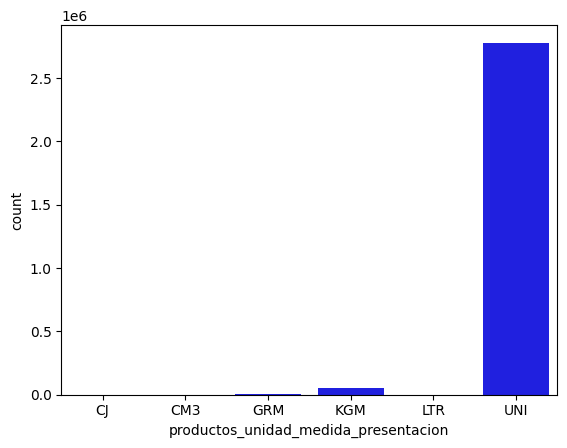

In [620]:
print(datos['productos_unidad_medida_presentacion'].unique())
sns.countplot(data=datos, x='productos_unidad_medida_presentacion', color="blue")

productos_marca:

In [621]:
print(datos['productos_marca'].unique())

['NOSOTRAS', 'LUCCHETTI', 'TERRABUSI', 'TRESEMME', 'CARREFOUR', ..., 'GRANJA DE ORO', 'GABBY', 'BOSCA', 'KIS', 'VOLCAN DE MI TIERRA']
Length: 2107
Categories (2107, object): ['1 DE AGOSTO', '100% DISENO', '123', '123 LISTO', ..., 'ZUMUVA', 'ZUPAY', 'ZURU', 'ÑUKE']


Son demasiados para poder graficarlos adecuadamente, así que listamos los 25 más frecuentes:

In [622]:
# Obtengo las 25 marcas con más productos/precios, la frecuencia y su porcentaje
productos_marca = datos['productos_marca'].value_counts().reset_index()
productos_marca.columns = ['productos_marca', 'frecuencia']
productos_marca = productos_marca.sort_values(by="frecuencia", ascending=False)
productos_marca["porcentaje"] = productos_marca["frecuencia"] / productos_marca["frecuencia"].sum() * 100
productos_marca = productos_marca.head(25)

print(productos_marca)

         productos_marca  frecuencia  porcentaje
0                    S/D      242686    8.558288
1              CARREFOUR      224708    7.924296
2      CARREFOUR CLASSIC      114550    4.039590
3               GENERICO      101126    3.566194
4                 BULNEZ       66493    2.344866
5      CARREFOUR CRISTAL       49021    1.728719
6          LA SERENISIMA       37932    1.337667
7         CARREFOUR HOME       23625    0.833132
8    CARREFOUR ESSENTIAL       21735    0.766482
9                  ARCOR       19320    0.681317
10                  DOVE       17703    0.624294
11       CARREFOUR EXTRA       14983    0.528373
12  CARREFOUR EL MERCADO       14551    0.513139
13                ALGABO       14203    0.500867
14        CARREFOUR SOFT       13543    0.477592
15                 KNORR       12080    0.426000
16             LUCCHETTI       11808    0.416407
17                   CIF       11799    0.416090
18                 SEDAL       11219    0.395636
19             EXQUI

Como vemos, el mayor porcentaje (8.56%) es de marca sin definir. Podemos ver que luego entre las más frecuentes siguen marcas de Carrefour, genéricas, 'Bulnez' y 'La Serenísima'. A partir de la marca séptima de mayor frecuencia, los porcentajes son menores que 1.

productos_unidad_medida_referencia:

['UNI', 'GRM', 'CM3', 'GRS', 'LTR', ..., 'PAN', 'MIL', 'GR1', 'LM1', 'ML1']
Length: 14
Categories (14, object): ['CM3', 'GR1', 'GRM', 'GRS', ..., 'ML1', 'MTR', 'PAN', 'UNI']


<Axes: xlabel='productos_unidad_medida_referencia', ylabel='count'>

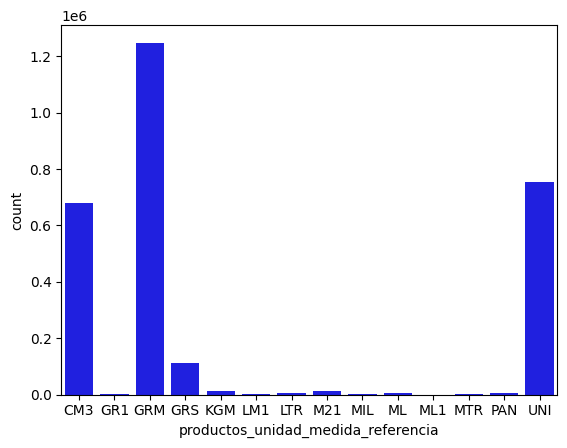

In [623]:
print(datos['productos_unidad_medida_referencia'].unique())
sns.countplot(data=datos, x='productos_unidad_medida_referencia', color="blue")

sucursales_nombre:

In [624]:
print(datos['sucursales_nombre'].unique())

['Caleta Olivia', 'Álvarez Thomas 372', 'Resistencia II', 'Champagnat', 'Pueyrredón 2120', ..., 'Av. Caseros 2423', 'Proxi Gral Las Heras 3315', 'Cosquín 78-80', 'México 1530', 'Gaona 3567']
Length: 561
Categories (561, object): ['11 de Septiembre 3910', '12 de Octubre 520', '24 DE SEPT. 1500', '25 de Mayo 2650', ..., 'Álvarez Jonte 3079', 'Álvarez Thomas 1996', 'Álvarez Thomas 372', 'Ángel Gallardo 940']


Son demasiados para poder graficarlos adecuadamente, así que listamos los 25 más frecuentes:

In [625]:
# Obtengo las 25 sucursales con más productos/precios, la frecuencia y su porcentaje
sucursales_nombre = datos['sucursales_nombre'].value_counts().reset_index()
sucursales_nombre.columns = ['sucursales_nombre', 'frecuencia']
sucursales_nombre = sucursales_nombre.sort_values(by="frecuencia", ascending=False)
sucursales_nombre["porcentaje"] = sucursales_nombre["frecuencia"] / sucursales_nombre["frecuencia"].sum() * 100
sucursales_nombre = sucursales_nombre.head(25)

print(sucursales_nombre)

      sucursales_nombre  frecuencia  porcentaje
0               Adrogué       24304    0.857077
1            San Martín       22323    0.787217
2              Salguero       21869    0.771207
3   Malvinas Argentinas       21829    0.769797
4         Vicente López       21740    0.766658
5         Mar del Plata       21705    0.765424
6            San Isidro       21684    0.764683
7          San Fernando       21074    0.743172
8              La Plata       21061    0.742713
9               Quilmes       21049    0.742290
10            Caballito       20864    0.735766
11       Córdoba Jardín       20733    0.731146
12        Córdoba Colon       20689    0.729595
13               Moreno       20557    0.724940
14                Pilar       20402    0.719474
15   Mendoza Guaymallén       20333    0.717040
16    Rosario Fisherton       20058    0.707343
17           Corrientes       19472    0.686677
18         Monte Grande       19292    0.680330
19            Concordia       19017    0

Como podemos ver ninguna sucursal supera el 1% de frecuencia, lo que nos dice que tiene una distribución altamente dispersa.

sucursales_tipo:

['Hipermercado', 'Autoservicio', 'Supermercado']
Categories (3, object): ['Autoservicio', 'Hipermercado', 'Supermercado']


<Axes: xlabel='sucursales_tipo', ylabel='count'>

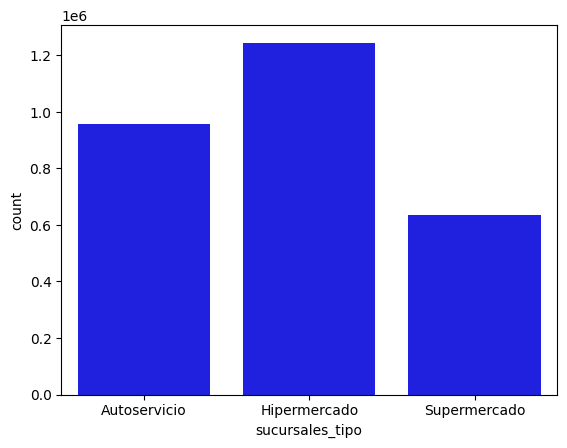

In [626]:
print(datos['sucursales_tipo'].unique())
sns.countplot(data=datos, x='sucursales_tipo', color="blue")

sucursales_barrio:

[NaN, 'Colegiales', 'Recoleta', 'Naon', 'Almagro', ..., 'Gral Paz', 'Don Bosco', 'Wilde', 'San Justo', 'Burzaco']
Length: 76
Categories (75, object): ['Agronomia', 'Almagro', 'Atalaya', 'Balvanera', ..., 'Villa Urquiza', 'Villa del Parque', 'Villa luro', 'Wilde']


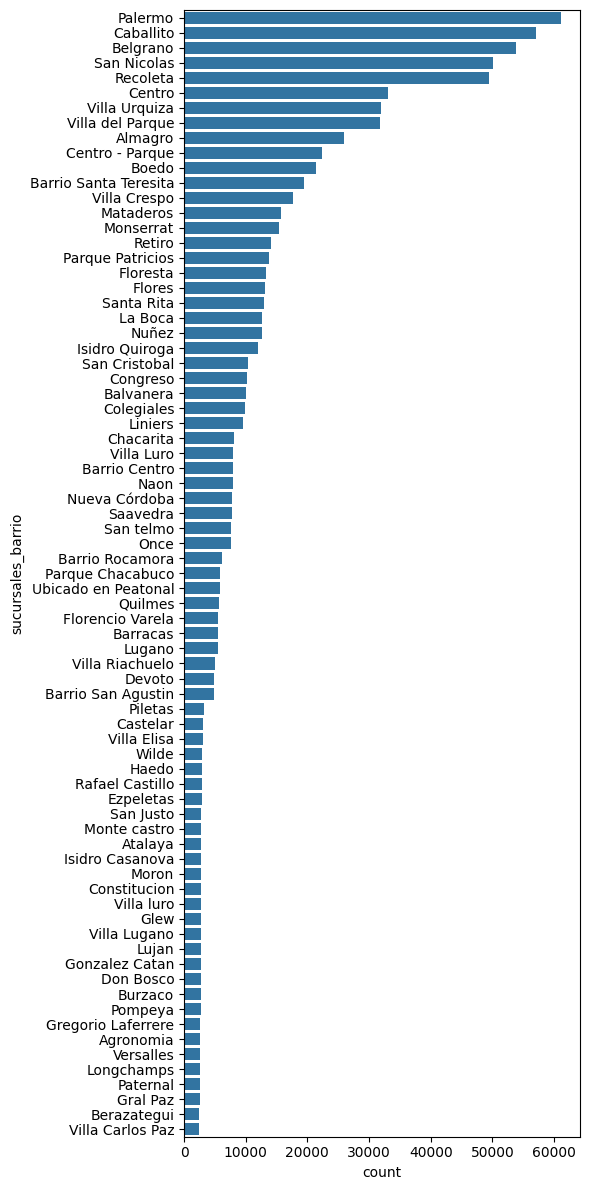

In [627]:
print(datos['sucursales_barrio'].unique())

plt.figure(figsize=(6, 12)) 
sns.countplot(
    data=datos,
    y='sucursales_barrio',
    order=datos['sucursales_barrio'].value_counts().index  # ordena de mayor a menor frecuencia
)
plt.tight_layout()
plt.show()

sucursales_codigo_postal:

[9011.0, 1427.0, 3500.0, 1629.0, 1428.0, ..., 1045.0, 1127.0, 5012.0, 1162.0, 1097.0]
Length: 212
Categories (212, float64): [1002.0, 1003.0, 1004.0, 1006.0, ..., 9120.0, 9400.0, 9410.0, 9420.0]


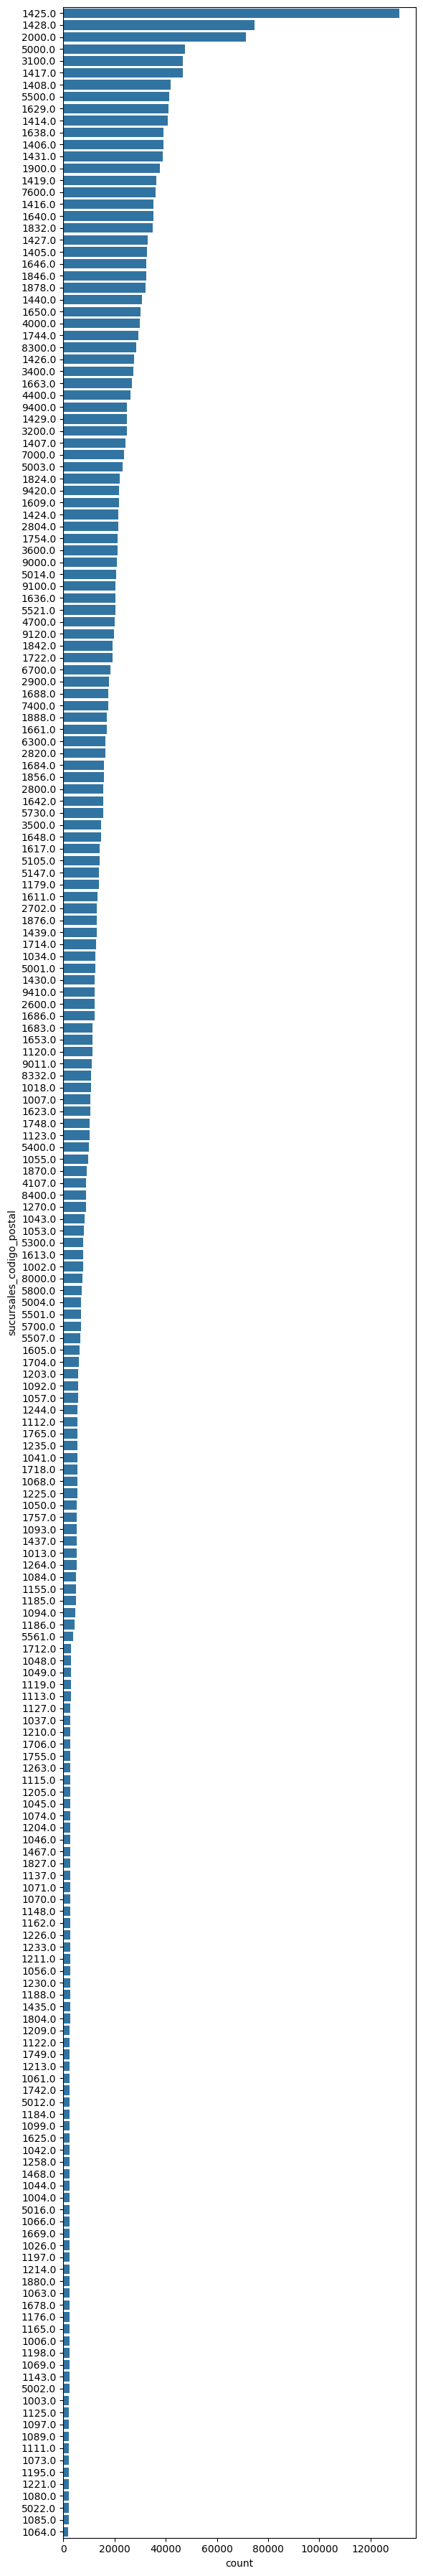

In [628]:
print(datos['sucursales_codigo_postal'].unique())
plt.figure(figsize=(6, 36)) 
sns.countplot(
    data=datos,
    y='sucursales_codigo_postal',
    order=datos['sucursales_codigo_postal'].value_counts().index  # ordena de mayor a menor frecuencia
)
plt.tight_layout()
plt.show()

sucursales_localidad:

['Santa Cruz', 'Ciudad Autónoma de Buenos Aires', 'Resistencia', 'Pilar', 'Villa Allende Lomas', ..., 'Monte Chingolo', 'Palomar', 'Adolfo Sordeaux', 'Paso del Rey', 'Burzaco']
Length: 124
Categories (124, object): ['3 de Febrero', 'Acassuso', 'Adolfo Sordeaux', 'Adrogué', ..., 'Villa Urquiza', 'Wilde', 'Yerba Buena', 'Zárate']


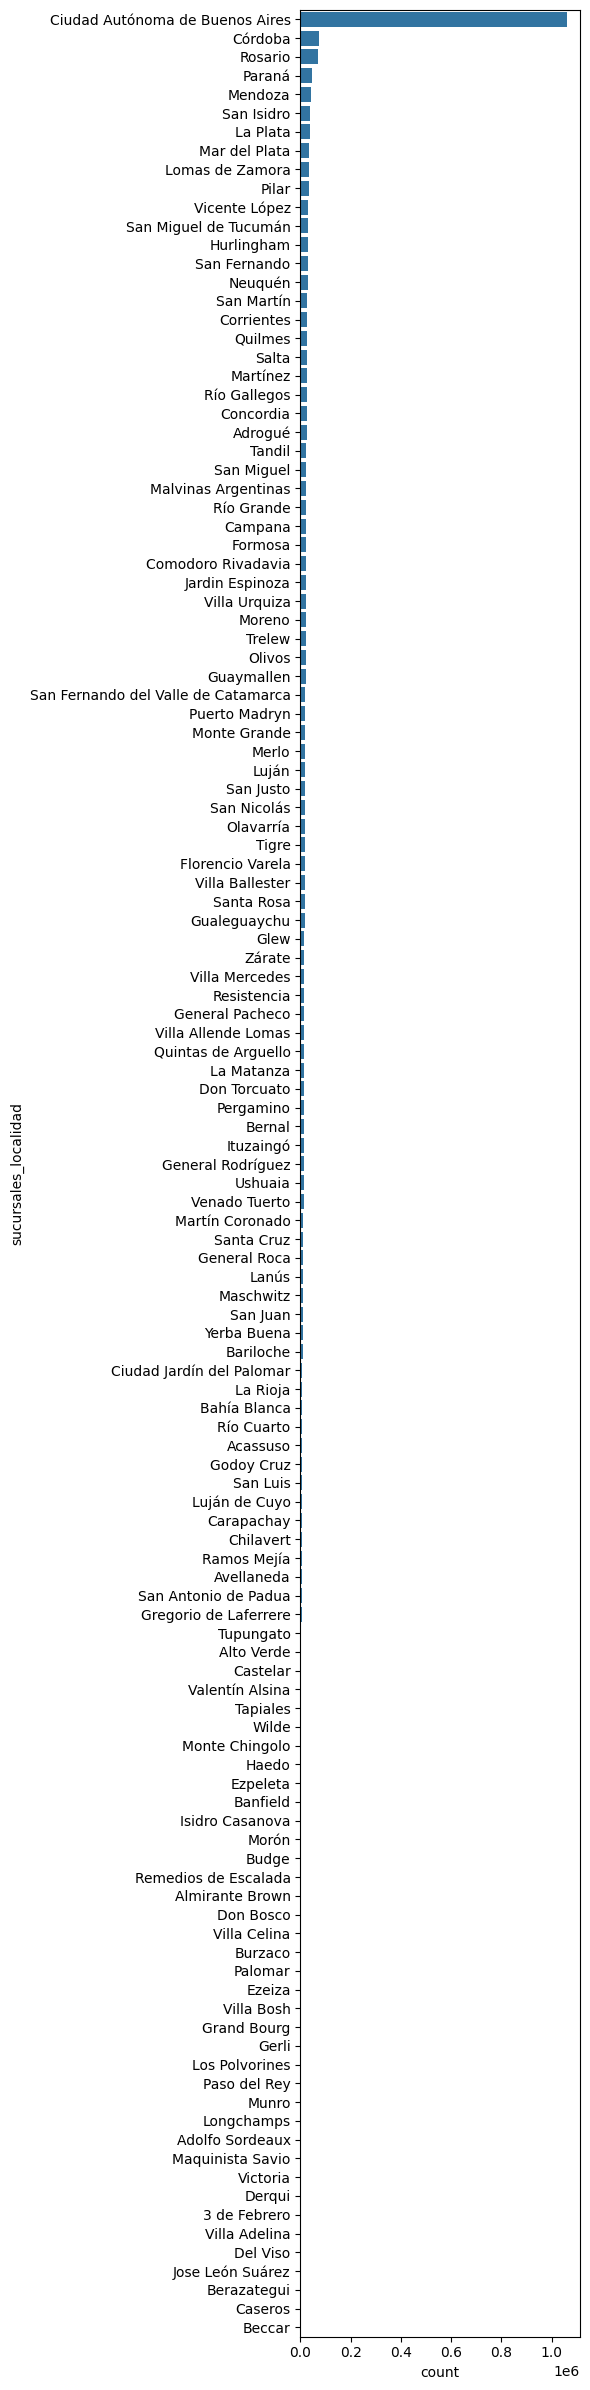

In [629]:
print(datos['sucursales_localidad'].unique())
plt.figure(figsize=(6, 24)) 
sns.countplot(
    data=datos,
    y='sucursales_localidad',
    order=datos['sucursales_localidad'].value_counts().index  # ordena de mayor a menor frecuencia
)
plt.tight_layout()
plt.show()

sucursales_provincia:

['AR-Z', 'AR-C', 'AR-H', 'AR-B', 'AR-X', ..., 'AR-U', 'AR-R', 'AR-P', 'AR-F', 'AR-K']
Length: 21
Categories (21, object): ['AR-A', 'AR-B', 'AR-C', 'AR-D', ..., 'AR-V', 'AR-W', 'AR-X', 'AR-Z']


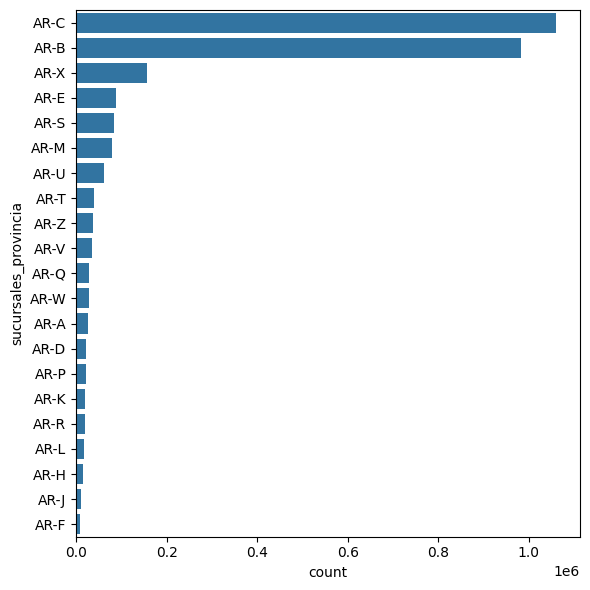

In [630]:
print(datos['sucursales_provincia'].unique())
plt.figure(figsize=(6, 6)) 
sns.countplot(
    data=datos,
    y='sucursales_provincia',
    order=datos['sucursales_provincia'].value_counts().index  # ordena de mayor a menor frecuencia
)
plt.tight_layout()
plt.show()

### Variables numéricas: estadística descriptiva

Las variables identificadas como numpericas son:
- producto_cantidad_presentacion
- productos_precio_lista
- productos_cantidad_referencia
- productos_precio_referencia


#### productos_cantidad_presentacion

Utilizamos el método **describe** que nos muetra información sobre las principales medidas estadísticas de nuestro conjunto de datos

In [631]:
print(datos['productos_cantidad_presentacion'].describe())

count    2835684.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: productos_cantidad_presentacion, dtype: float64


Todos los valores de esta columna son igual a 1. No aporta información.

#### productos_precio_lista

In [632]:
datos['productos_precio_lista'].describe()

count    2.835684e+06
mean     1.378489e+04
std      7.999113e+04
min      2.800000e-01
25%      1.809000e+03
50%      3.275000e+03
75%      6.790000e+03
max      7.349000e+06
Name: productos_precio_lista, dtype: float64

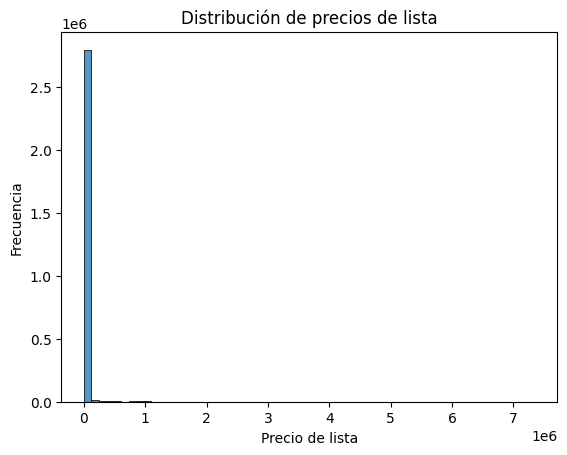

In [633]:
sns.histplot(datos['productos_precio_lista'], kde=False, bins=60)
plt.title('Distribución de precios de lista')
plt.xlabel('Precio de lista')
plt.ylabel('Frecuencia')
plt.show()

In [634]:
print(f"La varianza del precio de lista es: {datos['productos_precio_lista'].var()}")

La varianza del precio de lista es: 6398580348.694837


Al analizar la variable productos_precio_lista, se observó una alta dispersión en los valores, con presencia de valores atípicos que afectan la visualización y el análisis estadístico. Para obtener una representación más clara y enfocada en el comportamiento general de los precios, se decidió filtrar los datos hasta el percentil 95. Es decir, se excluyó el 5% de los precios más altos, que representan casos extremos poco frecuentes.

Este filtrado permite visualizar de forma más precisa la distribución de los precios y calcular medidas estadísticas representativas del conjunto principal de los datos. A continuación, se presenta un histograma que muestra la distribución de precios de lista hasta el percentil 95, incluyendo líneas de referencia para la media, la mediana y la moda.

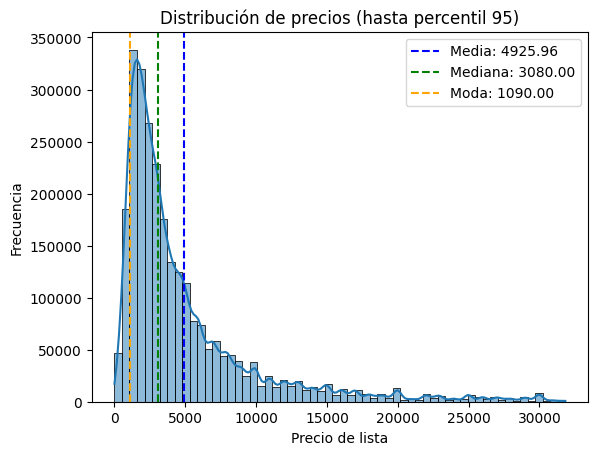

In [635]:
# Calculamos el percentil 95 y filtramos los datos
p95 = datos['productos_precio_lista'].quantile(0.95)
df_filtrado = datos[datos['productos_precio_lista'] <= p95]

# Calcular medidas estadísticas
media = df_filtrado['productos_precio_lista'].mean()
mediana = df_filtrado['productos_precio_lista'].median()
moda = df_filtrado['productos_precio_lista'].mode().iloc[0]  # solo la primera moda

# Crear el histograma
sns.histplot(df_filtrado['productos_precio_lista'], kde=True, bins=60)
plt.title('Distribución de precios (hasta percentil 95)')
plt.xlabel('Precio de lista')
plt.ylabel('Frecuencia')

# Agregar líneas verticales para media, mediana y moda
plt.axvline(media, color='blue', linestyle='--', label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
plt.axvline(moda, color='orange', linestyle='--', label=f'Moda: {moda:.2f}')

# Mostrar leyenda
plt.legend()
plt.show()

**Skewness**

Como se puede apreciar en el gráfico, la distribución de esta variable presenta una **asimetría positiva**. Calculamos la métrica **Skewness** basada en la fórmula de Fisher-Pearson de tercer momento central estandarizado.

$$
\text{Skewness} = \frac{n}{(n - 1)(n - 2)} \sum_{i=1}^{n} \left( \frac{x_i - \bar{x}}{s} \right)^3
$$

In [636]:
#Para toda la muetra
print(f"Skewness = {datos['productos_precio_lista'].skew()}")

Skewness = 17.502362931479542


In [637]:
#para el percentil 95
print(f"Skewness = {df_filtrado['productos_precio_lista'].skew()}")


Skewness = 2.409522499999975


En ambos casos el valor es >>1, lo que se considera altamente asimétrica positiva.

**Curtosis en exceso**


Indica cuántos datos hay en las “colas” de las distribución y (generalmente) que tan afilado o plano es el pico comparado con una Normal.
$$
\text{CurtosisExceso} = \frac{1}{n - 1} \sum \left( \frac{x_i - \bar{x}}{s} \right)^4 - 3
$$


In [638]:

k = df_filtrado['productos_precio_lista'].kurt()

print(f"Curtosis en exceso:{k}")

Curtosis en exceso:6.538648440549807


El resultado es mayor que cero, por lo que se denomina **leptocúrtica**

#### productos_cantidad_referencia

In [639]:
datos['productos_cantidad_referencia'].describe()

count    2.835684e+06
mean     3.362810e+02
std      4.952497e+02
min      0.000000e+00
25%      7.000000e+00
50%      1.750000e+02
75%      5.000000e+02
max      8.000000e+03
Name: productos_cantidad_referencia, dtype: float64

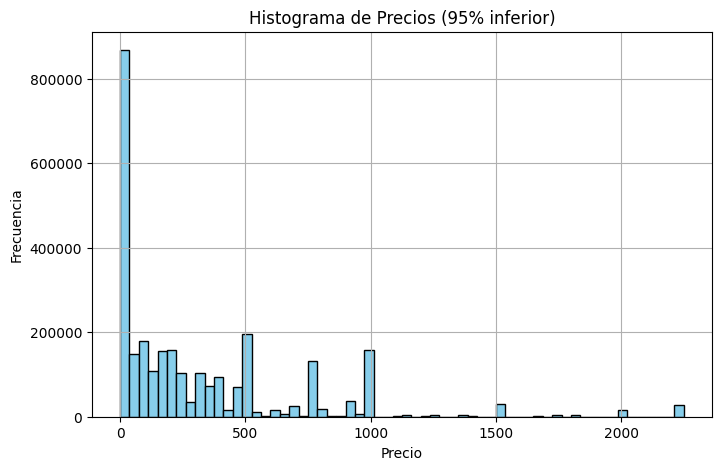

In [640]:
#Filtramos los datos con catidades menor a 2500 para elimiar los datos muy alejados y apreciar mejor el histograma
plt.figure(figsize=(8, 5))
cantidades_referencia= datos[datos['productos_cantidad_referencia']<2500]
plt.hist(cantidades_referencia['productos_cantidad_referencia'], bins=60, color='skyblue', edgecolor='black')
plt.title('Histograma de Precios (95% inferior)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#### productos_precio_referencia

In [641]:
datos['productos_precio_referencia'].describe()

count    2.835684e+06
mean     2.498746e+04
std      1.886987e+05
min      1.600000e-01
25%      3.675000e+03
50%      8.622220e+03
75%      1.853846e+04
max      3.328889e+07
Name: productos_precio_referencia, dtype: float64

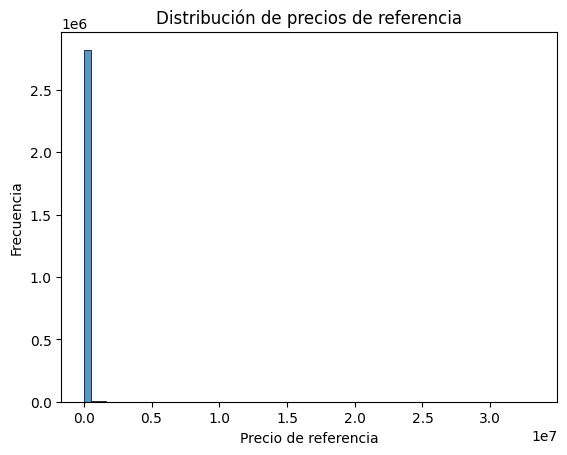

In [642]:
sns.histplot(datos['productos_precio_referencia'], kde=False, bins=60)
plt.title('Distribución de precios de referencia')
plt.xlabel('Precio de referencia')
plt.ylabel('Frecuencia')
plt.show()

In [643]:
print(f"La varianza del precio de referencia es: {datos['productos_precio_referencia'].var()}")

La varianza del precio de referencia es: 35607207493.45944


La varianza del precio de referncia es aún mayor que el del precio de lista. Filtramos hasta el percentil 95

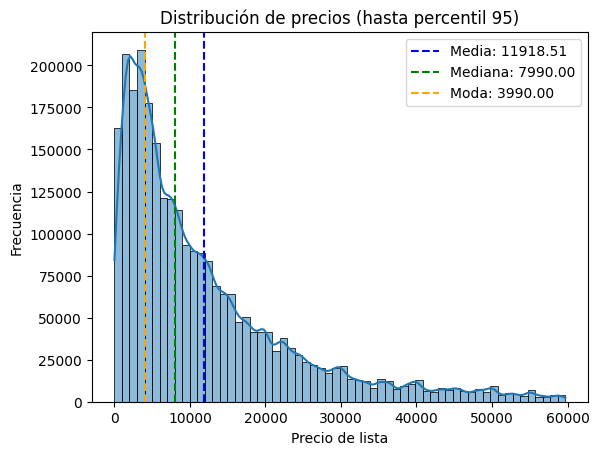

In [644]:
# Calculamos el percentil 95 y filtramos los datos
p95 = datos['productos_precio_referencia'].quantile(0.95)
df_filtrado = datos[datos['productos_precio_referencia'] <= p95]

# Calcular medidas estadísticas
media = df_filtrado['productos_precio_referencia'].mean()
mediana = df_filtrado['productos_precio_referencia'].median()
moda = df_filtrado['productos_precio_referencia'].mode().iloc[0]  # solo la primera moda

# Crear el histograma
sns.histplot(df_filtrado['productos_precio_referencia'], kde=True, bins=60)
plt.title('Distribución de precios (hasta percentil 95)')
plt.xlabel('Precio de lista')
plt.ylabel('Frecuencia')

# Agregar líneas verticales para media, mediana y moda
plt.axvline(media, color='blue', linestyle='--', label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
plt.axvline(moda, color='orange', linestyle='--', label=f'Moda: {moda:.2f}')

# Mostrar leyenda
plt.legend()
plt.show()

**Skewness**

In [645]:
#Para toda la muetra
print(f"Skewness = {datos['productos_precio_referencia'].skew()}")

Skewness = 93.22221819167478


In [646]:
#para el percentil 95
print(f"Skewness = {df_filtrado['productos_precio_referencia'].skew()}")


Skewness = 1.649350614856504


En ambos casos el vaaor es >>1, lo que se considera altamente asimétrica positiva.

**Curtosis en exceso**


In [647]:

k = df_filtrado['productos_precio_referencia'].kurt()

print(f"Curtosis en exceso:{k}")

Curtosis en exceso:2.598545128987367


El resultado es mayor que cero, por lo que se denomina **leptocúrtica**

#### coordenadas geográficas

Vamos a visializar las sucursales de los comercios en el mapa de Argenina

/var/folders/wl/620f1rg12p3bsd3m41yfv7y40000gn/T/ipykernel_29640/4203234045.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  productos_por_sucursal=datos.groupby('id_sucursal').agg(


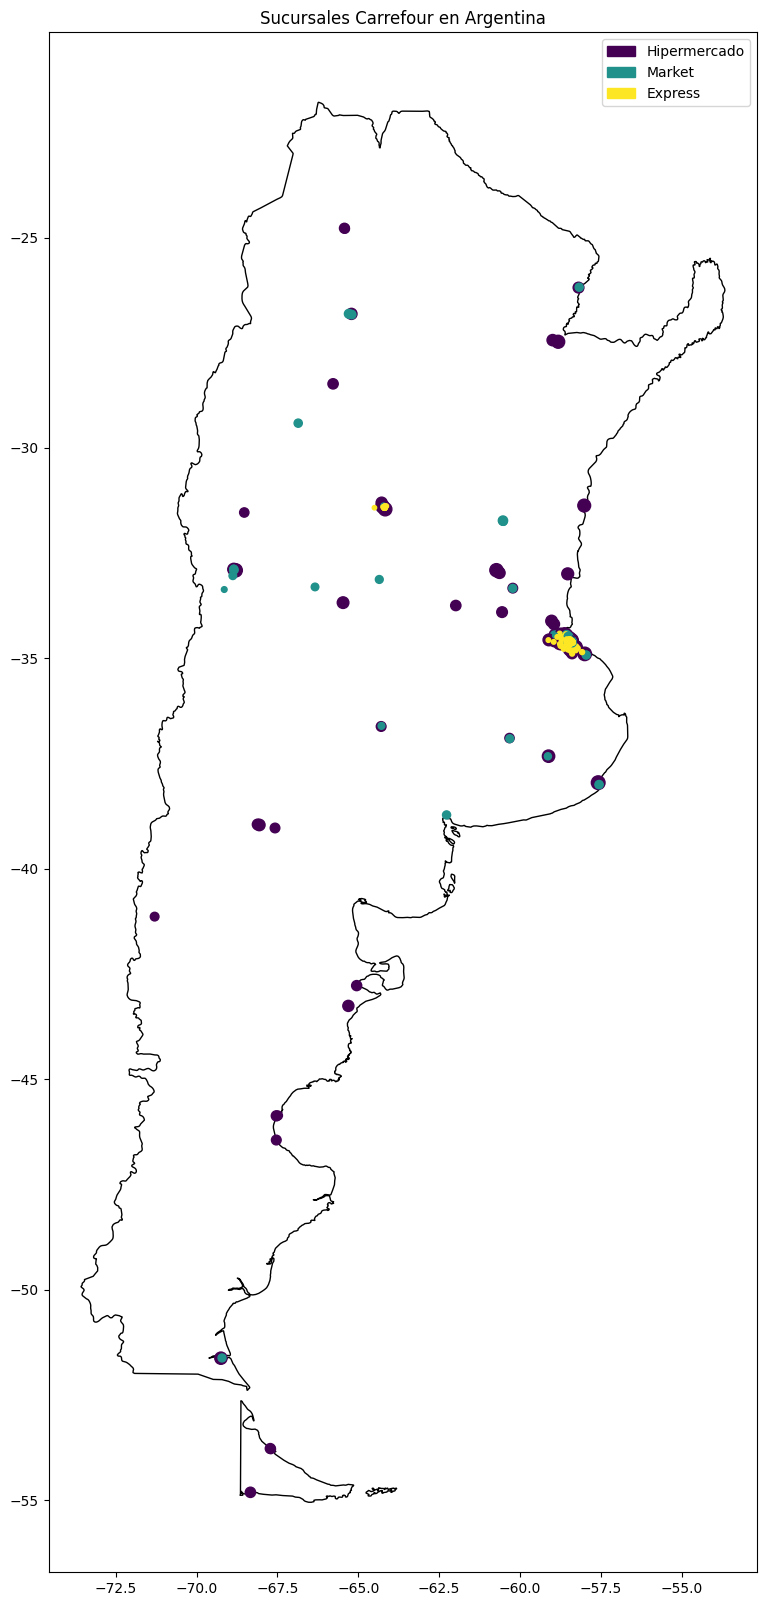

In [648]:
# Usaremos un archivo GeoJSON libre para generar el mapa de Argentina 

url_argentina = 'https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson'
world = gpd.read_file(url_argentina)
# Filtrar solo Argentina
argentina = world[world['name'] == 'Argentina']
#Agrupamos los datos por código de sucursal y contamos la cantidad de prouctos de cada una
productos_por_sucursal=datos.groupby('id_sucursal').agg(
    {   'id_sucursal':'first',
        'comercio_bandera_nombre':'first',
        'sucursales_tipo':'first',
        'sucursales_latitud': 'first',
        'sucursales_longitud': 'first',
        'comercio_bandera_nombre': 'first',
        'id_bandera_x':'first',
        'id_producto': 'count' 
    }
)
#Generamos la s estructuras de datos necesarias de entrada para renderizar el mapa
sucursales_id=productos_por_sucursal['id_sucursal'].to_list()
coordenadas=list(zip(productos_por_sucursal['sucursales_longitud'],productos_por_sucursal['sucursales_latitud']))
#Creamos un mapa de color en base a los valores del campo id_bandera_x (1,2,3) que determina si el comercio es un Hipermercado, Market o Express
norm = plt.Normalize(vmin=1, vmax=3)
cmap = plt.get_cmap('viridis')  #

colores = [cmap(norm(val)) for val in productos_por_sucursal['id_bandera_x']]

escalar=productos_por_sucursal['id_producto'].max()/100
sizes=[int(val/escalar) for val in productos_por_sucursal['id_producto']]


productos_por_sucursal.head()

# Convertir a GeoDataFrame
puntos = gpd.GeoDataFrame(
    {'pv': sucursales_id},
    geometry=[Point(lon, lat) for lon, lat in coordenadas],
    crs='EPSG:4326'  # Sistema de coordenadas WGS84
)
patches = [
    mpatches.Patch(color=cmap(norm(1)), label='Hipermercado'),
    mpatches.Patch(color=cmap(norm(2)), label='Market'),
    mpatches.Patch(color=cmap(norm(3)), label='Express')
]

# Generar el gráfico
ax = argentina.plot(figsize=(20, 20), color='white', edgecolor='black')
puntos.plot(ax=ax, color=colores, marker='o', markersize=sizes)
plt.title("Sucursales Carrefour en Argentina")
plt.legend(handles=patches, loc='upper right')
plt.show()

El gráfico muestra la ubicación geográfica de las sucursales diferenciados por tipo de sucursal según el color. La dimensión de los puntos indica la cantidad de productos que se venden en esa sucursal. 

### Visualizaciones entre pares de variables


Investigamos relaciónes entre variables para descubir dependencias o relaciones entre ellas. Principalmente la variable precio_lista con el resto que es el target de nuestro problema.

Calculamos, mostramos y graficamos la matriz de correlación entre las variables más relevantes para detectar relaciones:

In [649]:
#Declaramos funciones para calcular la matriz de correlación

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1))) if n > 1 else 0

def eta_squared(cat, num):
    groups = [num[cat == c] for c in cat.unique()]
    if len(groups) < 2:
        return 0
    fvalue, _ = ss.f_oneway(*groups)
    eta = fvalue * (len(cat) - len(groups)) / (fvalue * (len(cat) - len(groups)) + len(cat) - 1)
    return eta

def mixed_correlation_matrix(df):
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
    all_cols = list(num_cols) + list(cat_cols)
    
    corr_matrix = pd.DataFrame(np.nan, index=all_cols, columns=all_cols)
    
    corr_numeric = df[num_cols].corr()
    corr_matrix.loc[num_cols, num_cols] = corr_numeric
    
    for c1 in cat_cols:
        for c2 in cat_cols:
            if c1 == c2:
                corr_matrix.loc[c1, c2] = 1.0
            else:
                corr_matrix.loc[c1, c2] = cramers_v(df[c1], df[c2])
    
    for c1 in cat_cols:
        for c2 in num_cols:
            val = eta_squared(df[c1], df[c2])
            corr_matrix.loc[c1, c2] = val
            corr_matrix.loc[c2, c1] = val
    
    return corr_matrix

/Users/jose/Code/PostgradoIAUBA/Analisis_de_datos/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/wl/620f1rg12p3bsd3m41yfv7y40000gn/T/ipykernel_29640/4055931023.py:18: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  fvalue, _ = ss.f_oneway(*groups)


                                      id_bandera_x  id_producto  \
id_bandera_x                              1.000000     0.107008   
id_producto                               0.107008     1.000000   
productos_cantidad_presentacion                NaN          NaN   
productos_precio_lista                   -0.126441    -0.053313   
productos_precio_referencia              -0.060897    -0.021470   
productos_cantidad_referencia             0.141683     0.074194   
productos_precio_unitario_promo1         -0.190438     0.096488   
productos_precio_unitario_promo2               NaN          NaN   
id_sucursal                                    NaN     0.984352   
productos_unidad_medida_presentacion      0.999175     0.999988   
productos_marca                           0.997861     0.999111   
productos_unidad_medida_referencia        0.999967     0.999885   
sucursales_tipo                           1.000000     0.999934   
sucursales_barrio                              NaN          Na

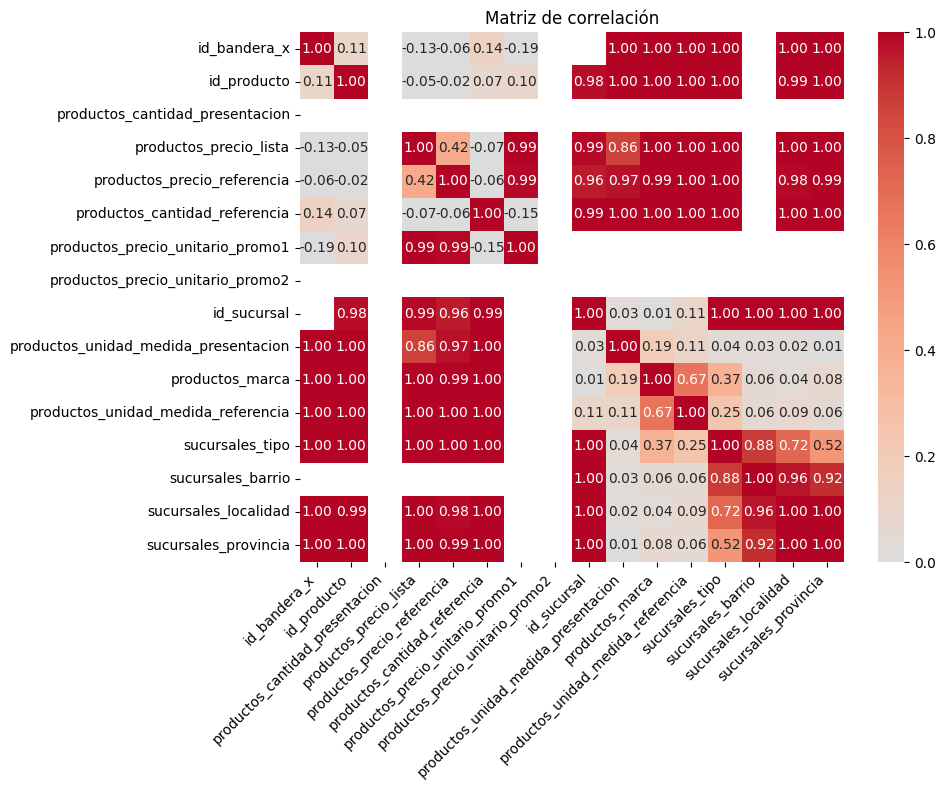

In [650]:
# Seleccionamos las variables más relevantes
ds_corr = datos[['id_bandera_x', 'id_sucursal', 'id_producto', 'productos_cantidad_presentacion', 'productos_unidad_medida_presentacion', 'productos_marca',
                 'productos_precio_lista', 'productos_precio_referencia', 'productos_cantidad_referencia', 'productos_unidad_medida_referencia',
                 'productos_precio_unitario_promo1', 'productos_precio_unitario_promo2', 'sucursales_tipo', 'sucursales_barrio', 'sucursales_localidad', 'sucursales_provincia']]


#Calculamos y mostramos la matriz de correlación
corr_mixta = mixed_correlation_matrix(ds_corr)
print(corr_mixta)

#Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mixta, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=0, vmax=1)
plt.title("Matriz de correlación")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nos interesa identificar los valores cercanos a 1 que muestran una relacion directa y cercanos a -1 que muestran una relacion inversa. Hay variables fuertemente relacionadas que en realidad nos interesan: por ejemplo variables entre sí misimas, sucursal con localidad, producto y marca, etc.



Ahora mostramos gráficos de dispersión entre variables relacionadas que nos parecen interesantes de entender mejor.

En algunos casos utilizamos los ids en lugar de los nombres y descripciones porque son muchos datos que no se visualizan adecuadamente y demoran mucho. Con los ids igual podemos hacernos una idea de la relacion entre las variables.



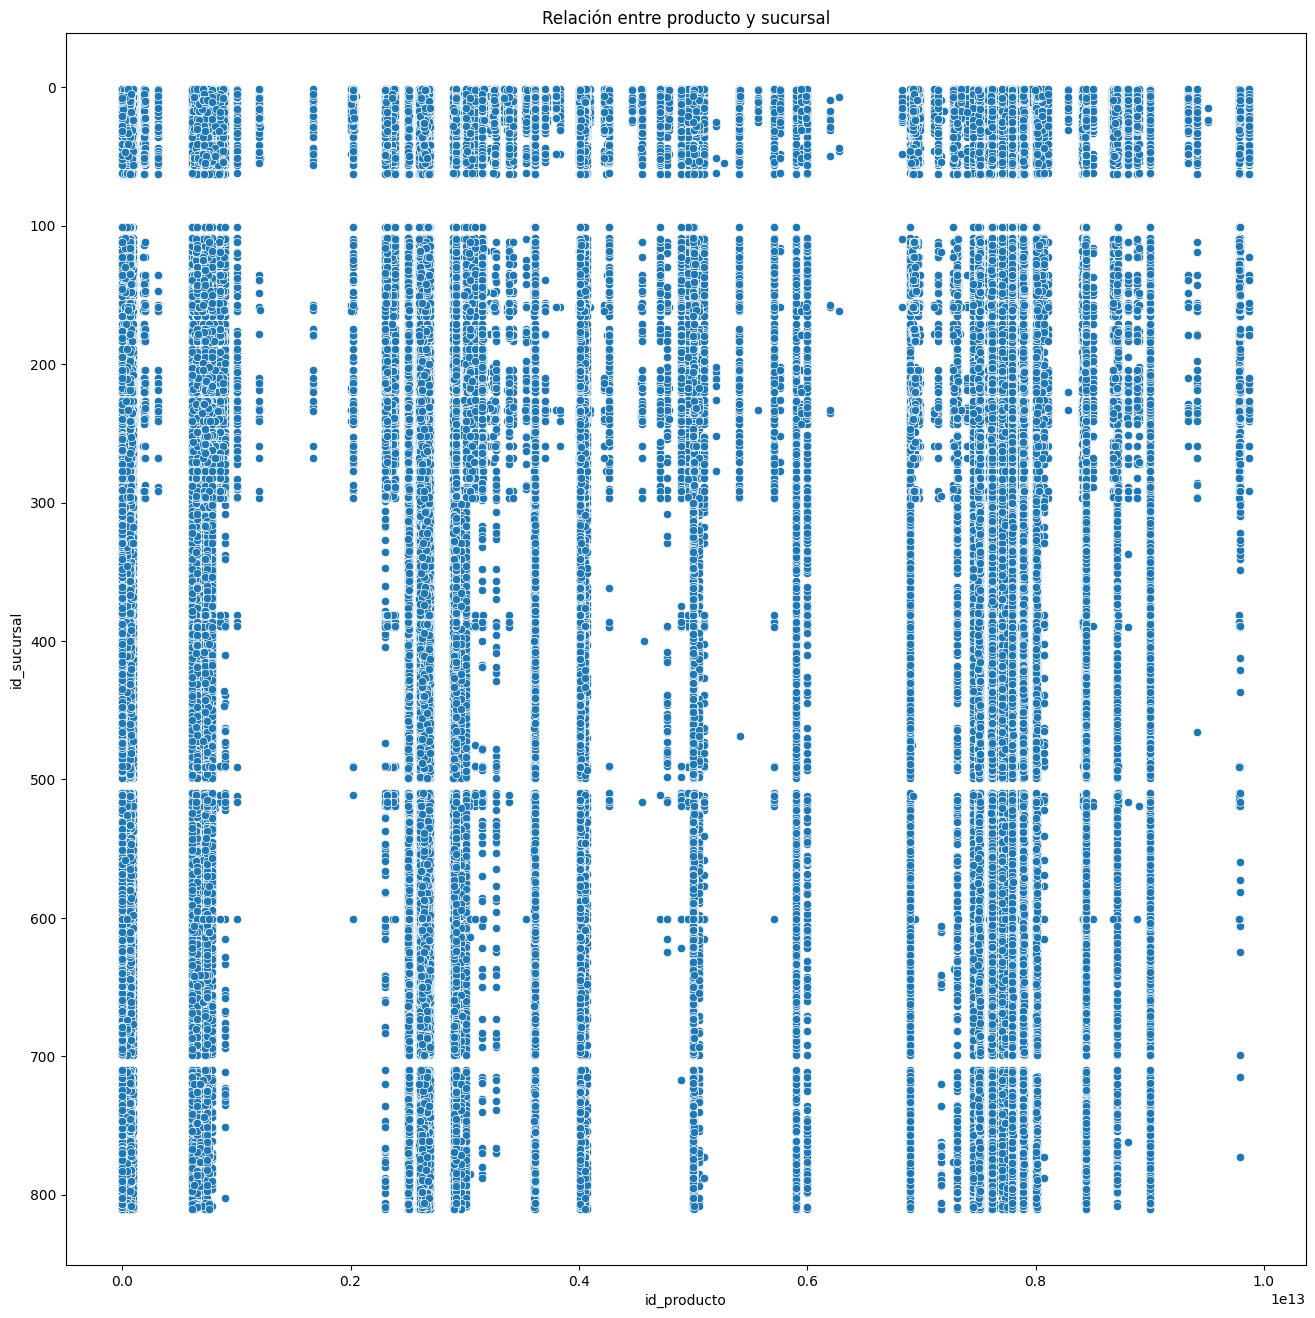

In [651]:
plt.figure(figsize=(16, 16))
sns.scatterplot(data=datos, x='id_producto', y='id_sucursal')
plt.title("Relación entre producto y sucursal")
plt.show()

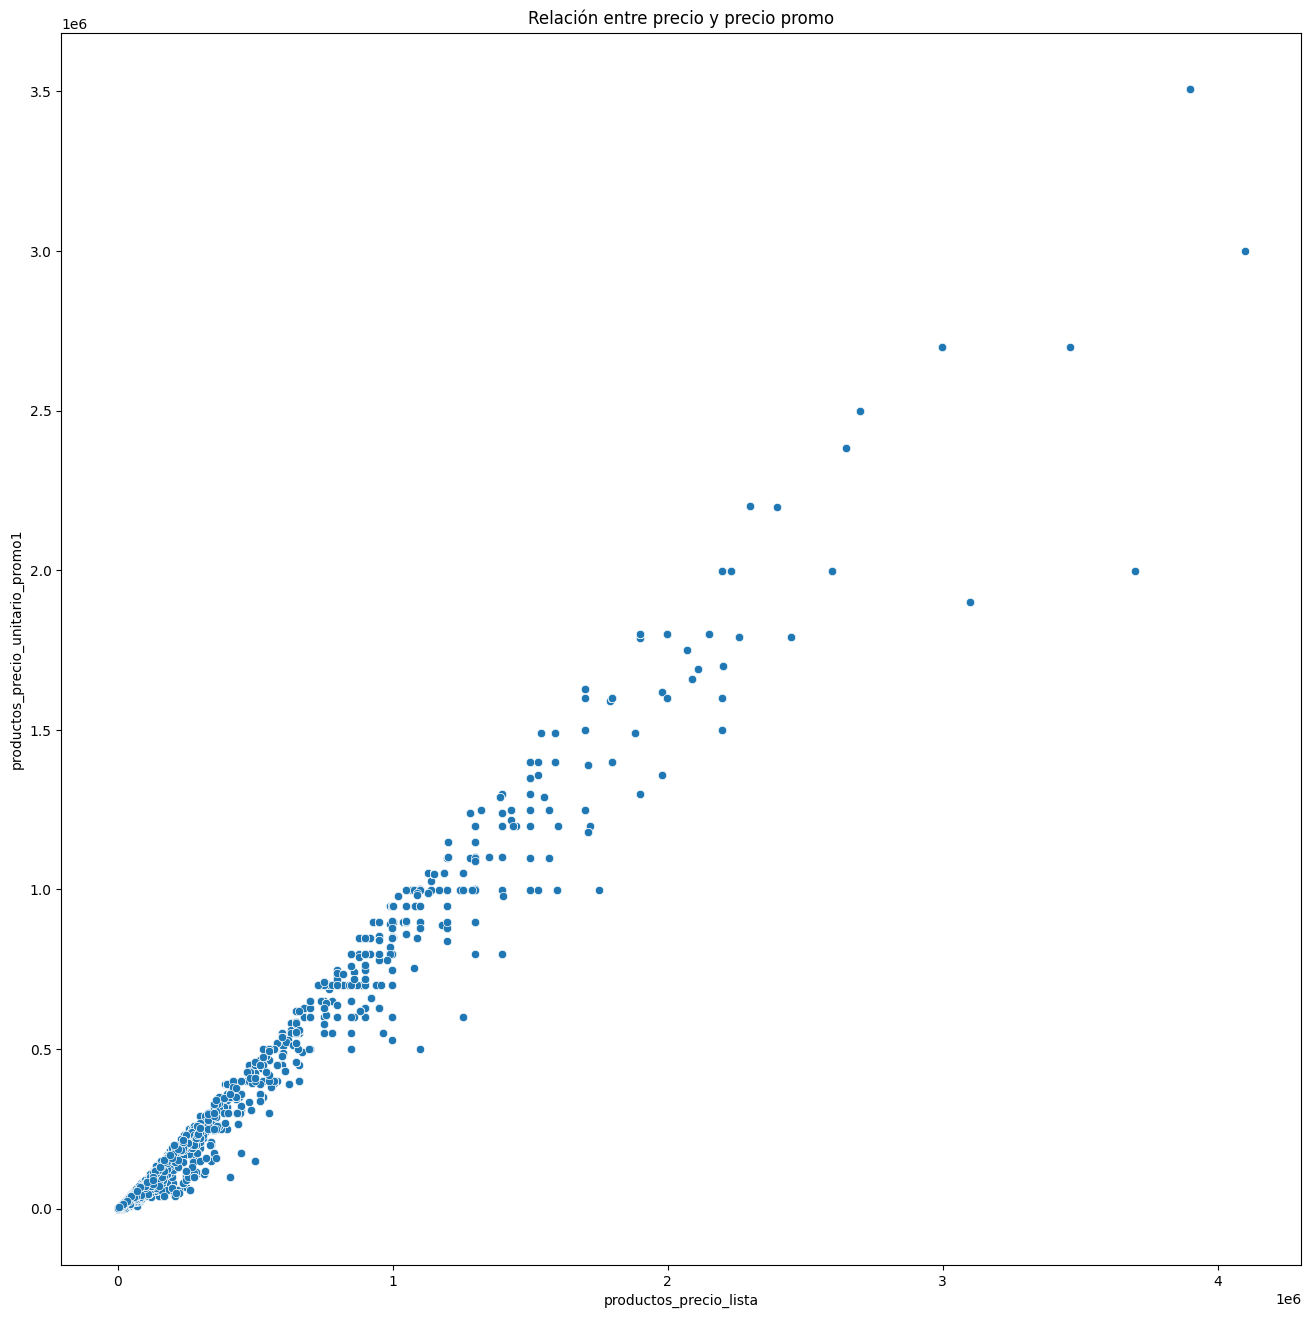

In [652]:
plt.figure(figsize=(16, 16))
sns.scatterplot(data=datos, x='productos_precio_lista', y='productos_precio_unitario_promo1')
plt.title("Relación entre precio y precio promo")
plt.show()

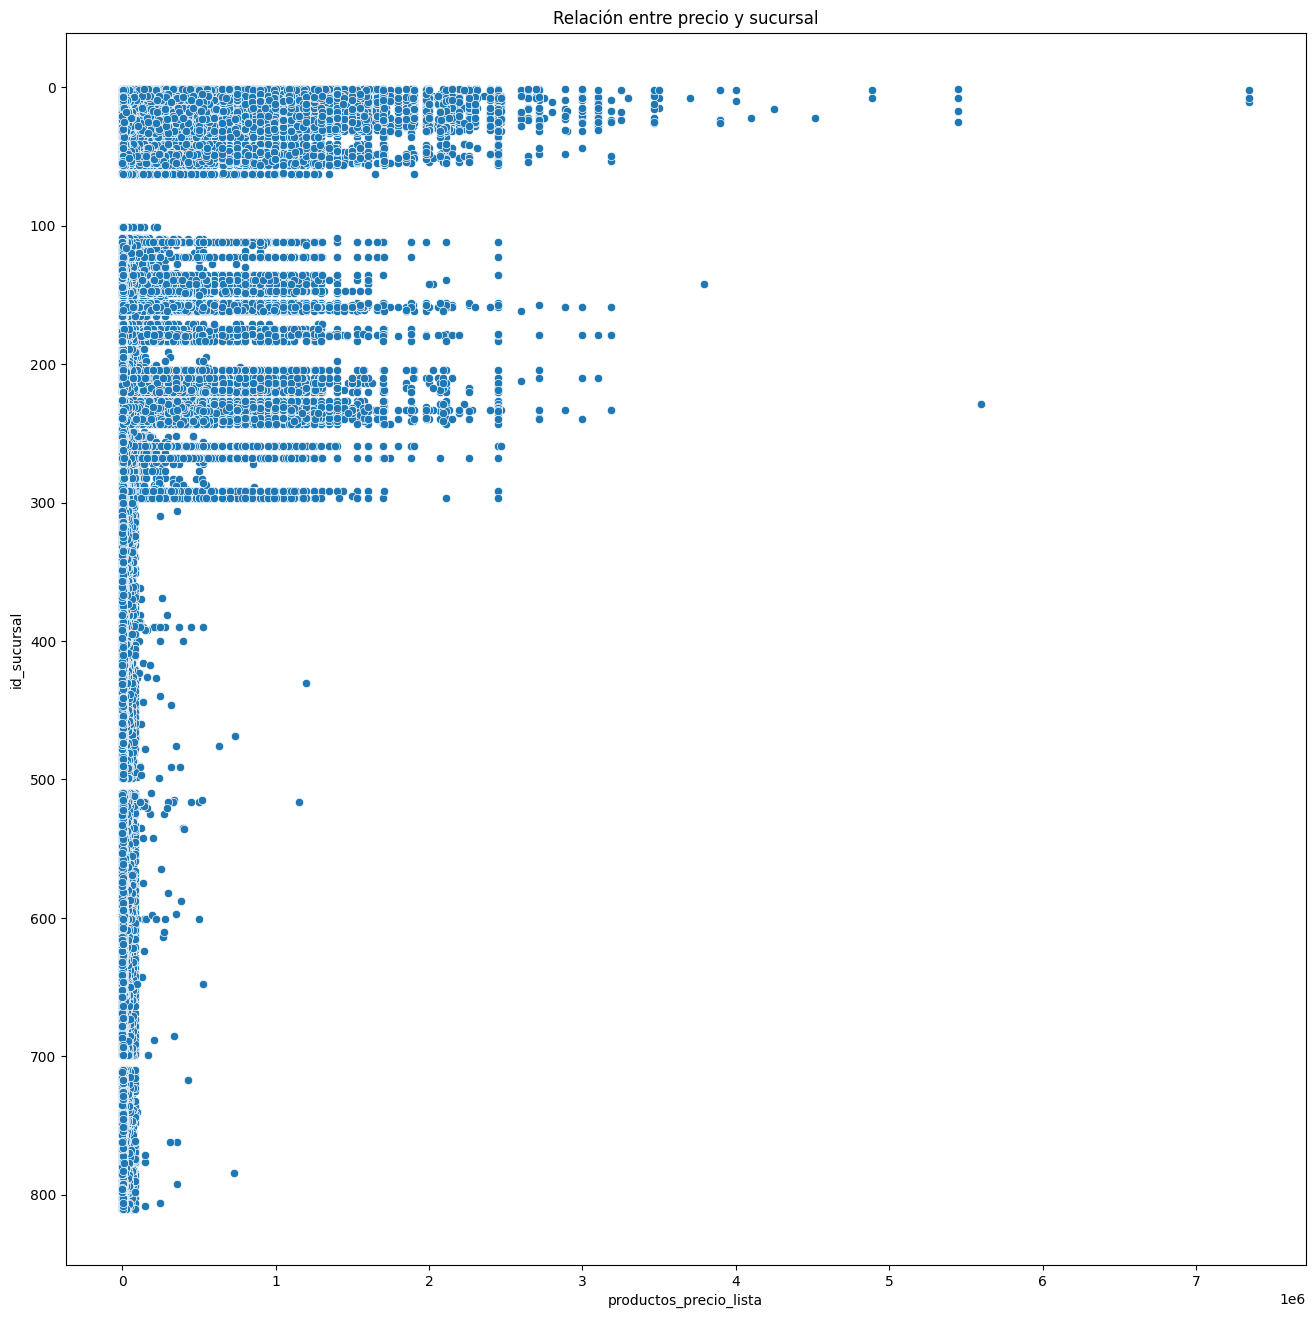

In [653]:
plt.figure(figsize=(16, 16))
sns.scatterplot(data=datos, x='productos_precio_lista', y='id_sucursal')
plt.title("Relación entre precio y sucursal")
plt.show()

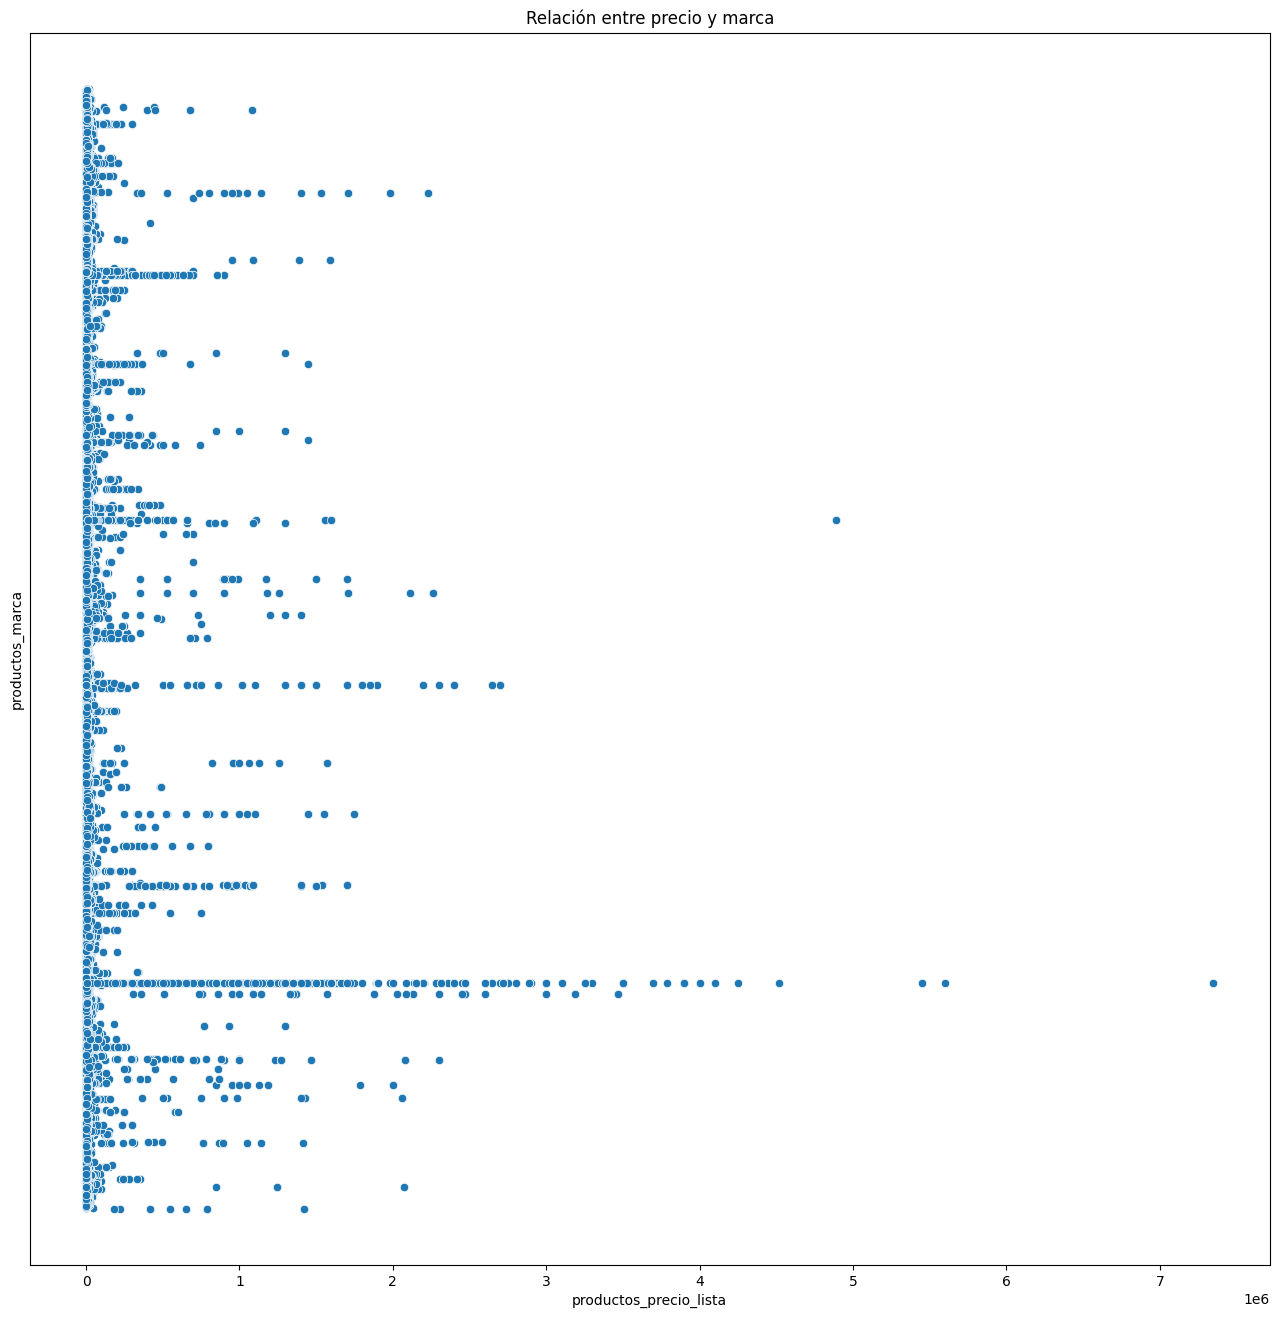

In [654]:
plt.figure(figsize=(16, 16))
sns.scatterplot(data=datos, x='productos_precio_lista', y='productos_marca')
plt.title("Relación entre precio y marca")
plt.yticks([])
plt.show()

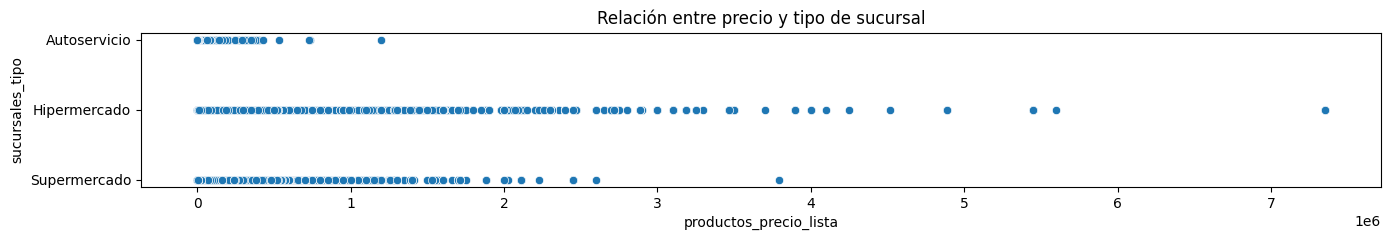

In [655]:
plt.figure(figsize=(16, 2))
sns.scatterplot(data=datos, x='productos_precio_lista', y='sucursales_tipo')
plt.title("Relación entre precio y tipo de sucursal")
plt.show()

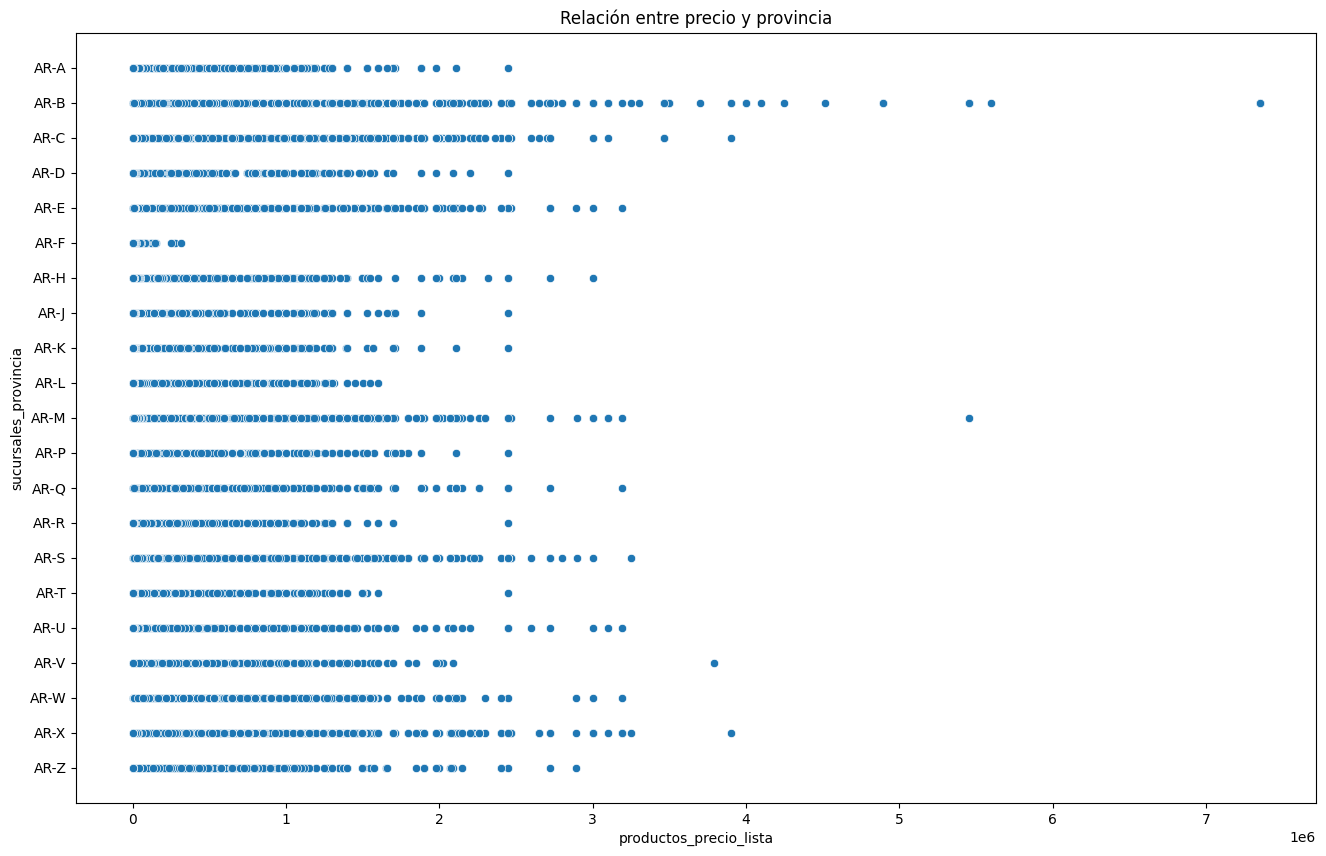

In [656]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=datos, x='productos_precio_lista', y='sucursales_provincia')
plt.title("Relación entre precio y provincia")
plt.show()

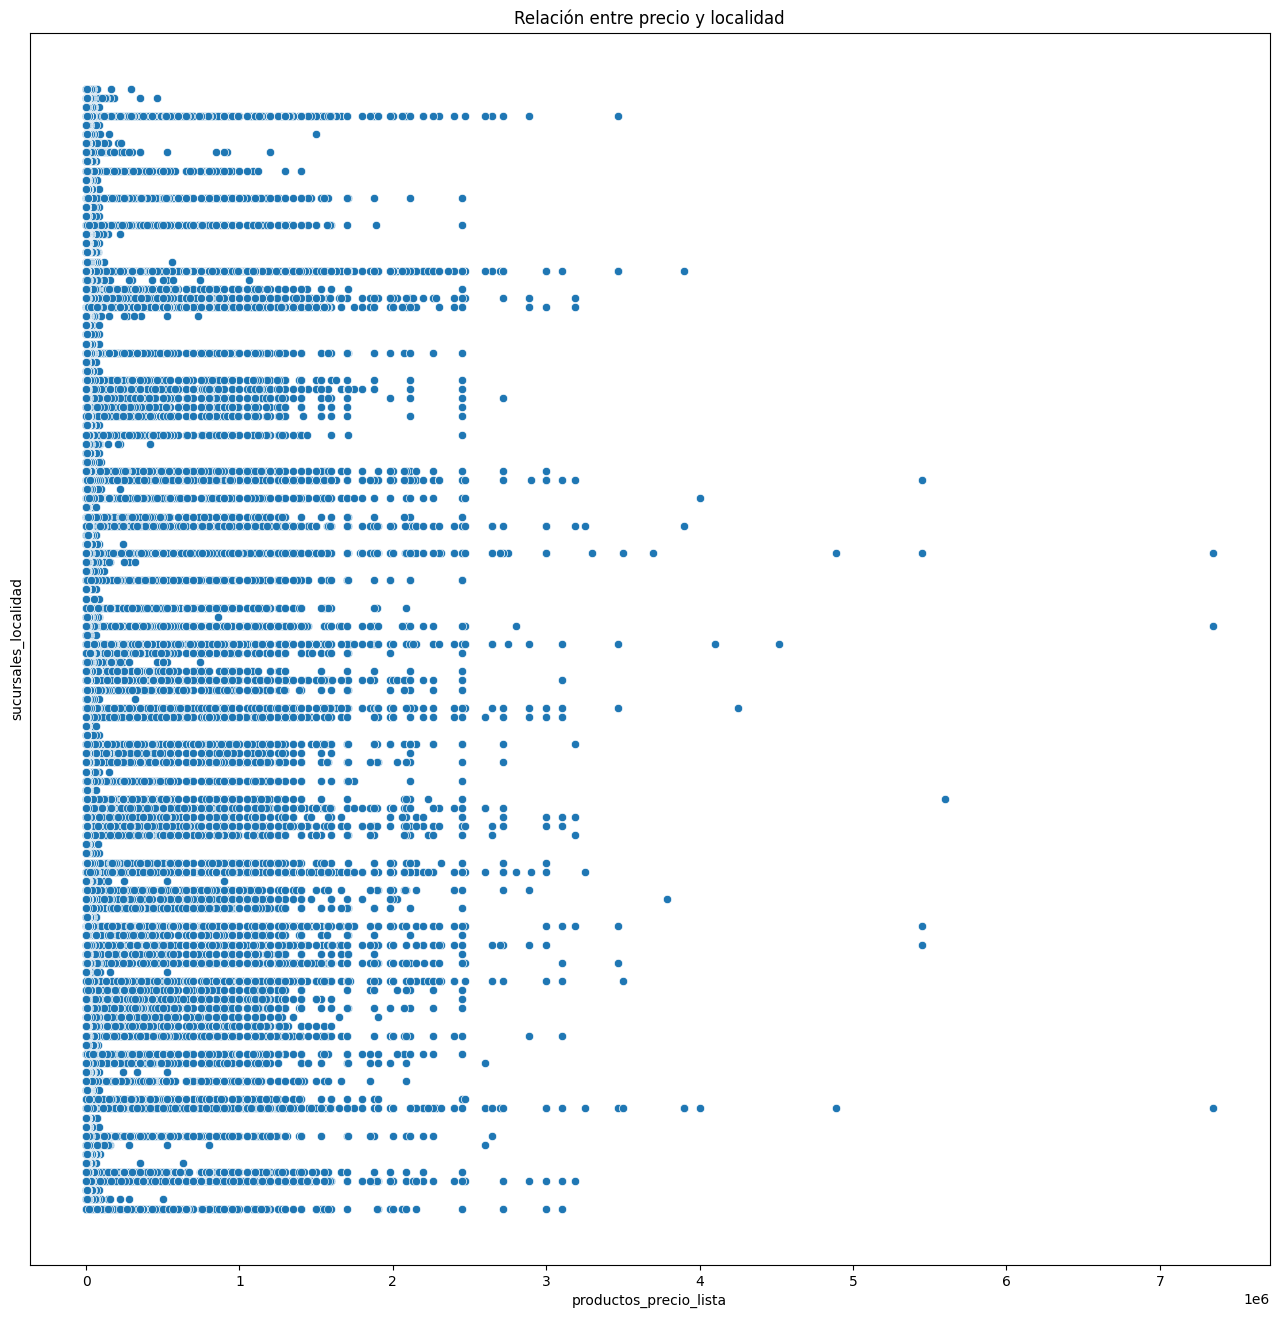

In [657]:
plt.figure(figsize=(16, 16))
sns.scatterplot(data=datos, x='productos_precio_lista', y='sucursales_localidad')
plt.title("Relación entre precio y localidad")
plt.yticks([])
plt.show()

Por último agrupamos y hacemos comparaciones por categorías entre variables relacionadas que nos parecen interesantes de entender mejor.

Si bien por el tipo de dateset estos gráficos no aportan todo el valor que sí tienen para otros tipos de datasets, visualizarnos nos ayudan a enter un poco mejor algunas rlaciones.

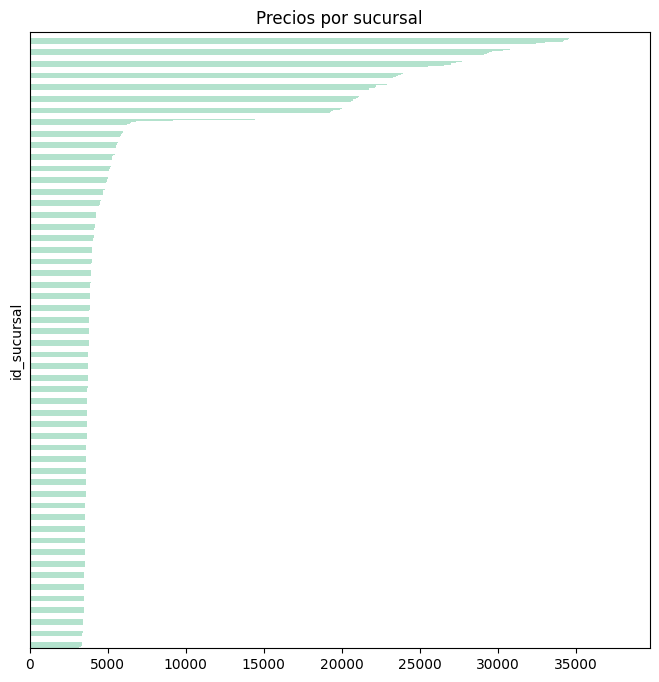

In [658]:
plt.figure(figsize=(8, 8))
(datos.groupby(['id_sucursal'], observed=True)['productos_precio_lista'].mean().sort_values().plot(kind='barh', colormap='Pastel2' , title='Precios por sucursal'))
plt.yticks([])
plt.show()

Vemos una distribución curiosa de precios si agrupamos por sucursal: necesitamos entender mejor esta relación.

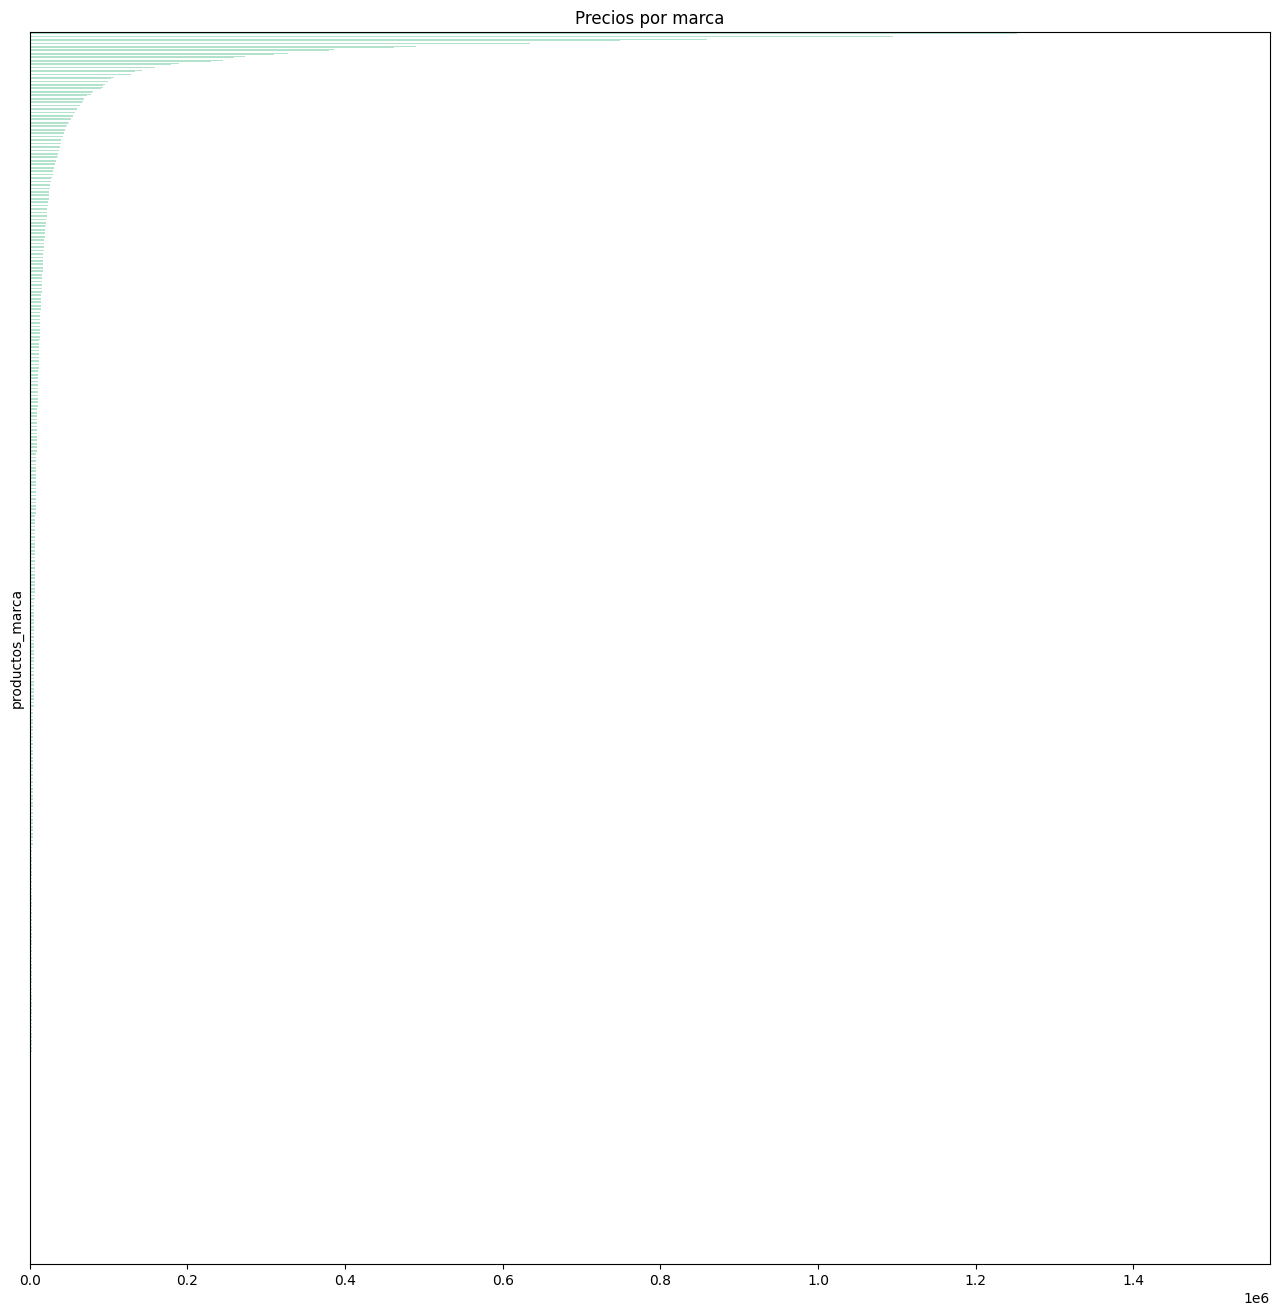

In [659]:
plt.figure(figsize=(16, 16))
(datos.groupby(['productos_marca'], observed=True)['productos_precio_lista'].mean().sort_values().plot(kind='barh', colormap='Pastel2' , title='Precios por marca'))
plt.yticks([])
plt.show()

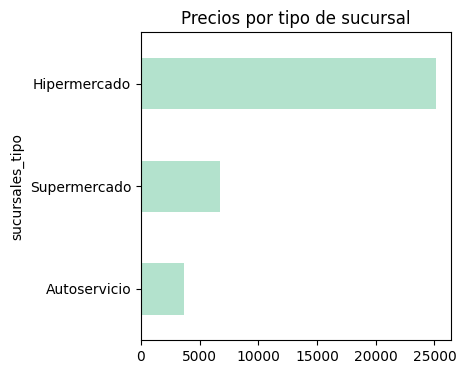

In [660]:
plt.figure(figsize=(4, 4))
(datos.groupby(['sucursales_tipo'], observed=True)['productos_precio_lista'].mean().sort_values().plot(kind='barh', colormap='Pastel2' , title='Precios por tipo de sucursal'))
plt.show()

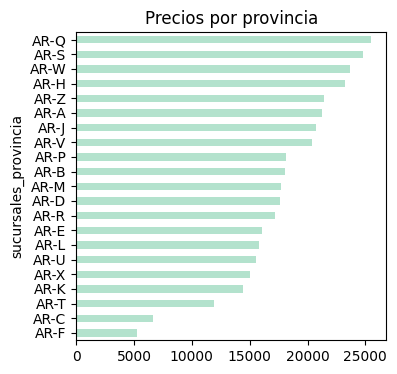

In [661]:
plt.figure(figsize=(4, 4))
(datos.groupby(['sucursales_provincia'], observed=True)['productos_precio_lista'].mean().sort_values().plot(kind='barh', colormap='Pastel2' , title='Precios por provincia'))
plt.show()

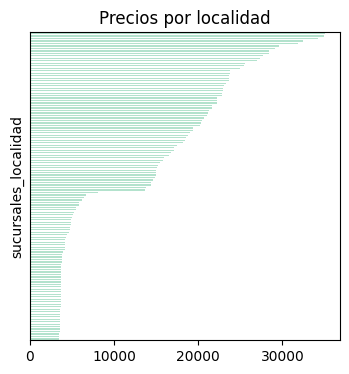

In [662]:
plt.figure(figsize=(4, 4))
(datos.groupby(['sucursales_localidad'], observed=True)['productos_precio_lista'].mean().sort_values().plot(kind='barh', colormap='Pastel2' , title='Precios por localidad'))
plt.yticks([])
plt.show()

## Revisión de valores faltantes

### Identificación de datos faltantes


In [663]:
datos.isna().mean().round(4)*100

id_bandera_x                              0.00
id_sucursal                               0.00
id_producto                               0.00
productos_ean                             0.00
productos_descripcion                     0.00
productos_cantidad_presentacion           0.00
productos_unidad_medida_presentacion      0.00
productos_marca                           0.00
productos_precio_lista                    0.00
productos_precio_referencia               0.00
productos_cantidad_referencia             0.00
productos_unidad_medida_referencia        0.00
productos_precio_unitario_promo1         95.55
productos_leyenda_promo1                 95.55
productos_precio_unitario_promo2        100.00
productos_leyenda_promo2                100.00
comercio_bandera_nombre                   0.00
sucursales_nombre                         0.00
sucursales_tipo                           0.00
sucursales_calle                          0.00
sucursales_numero                         1.78
sucursales_la

<Axes: >

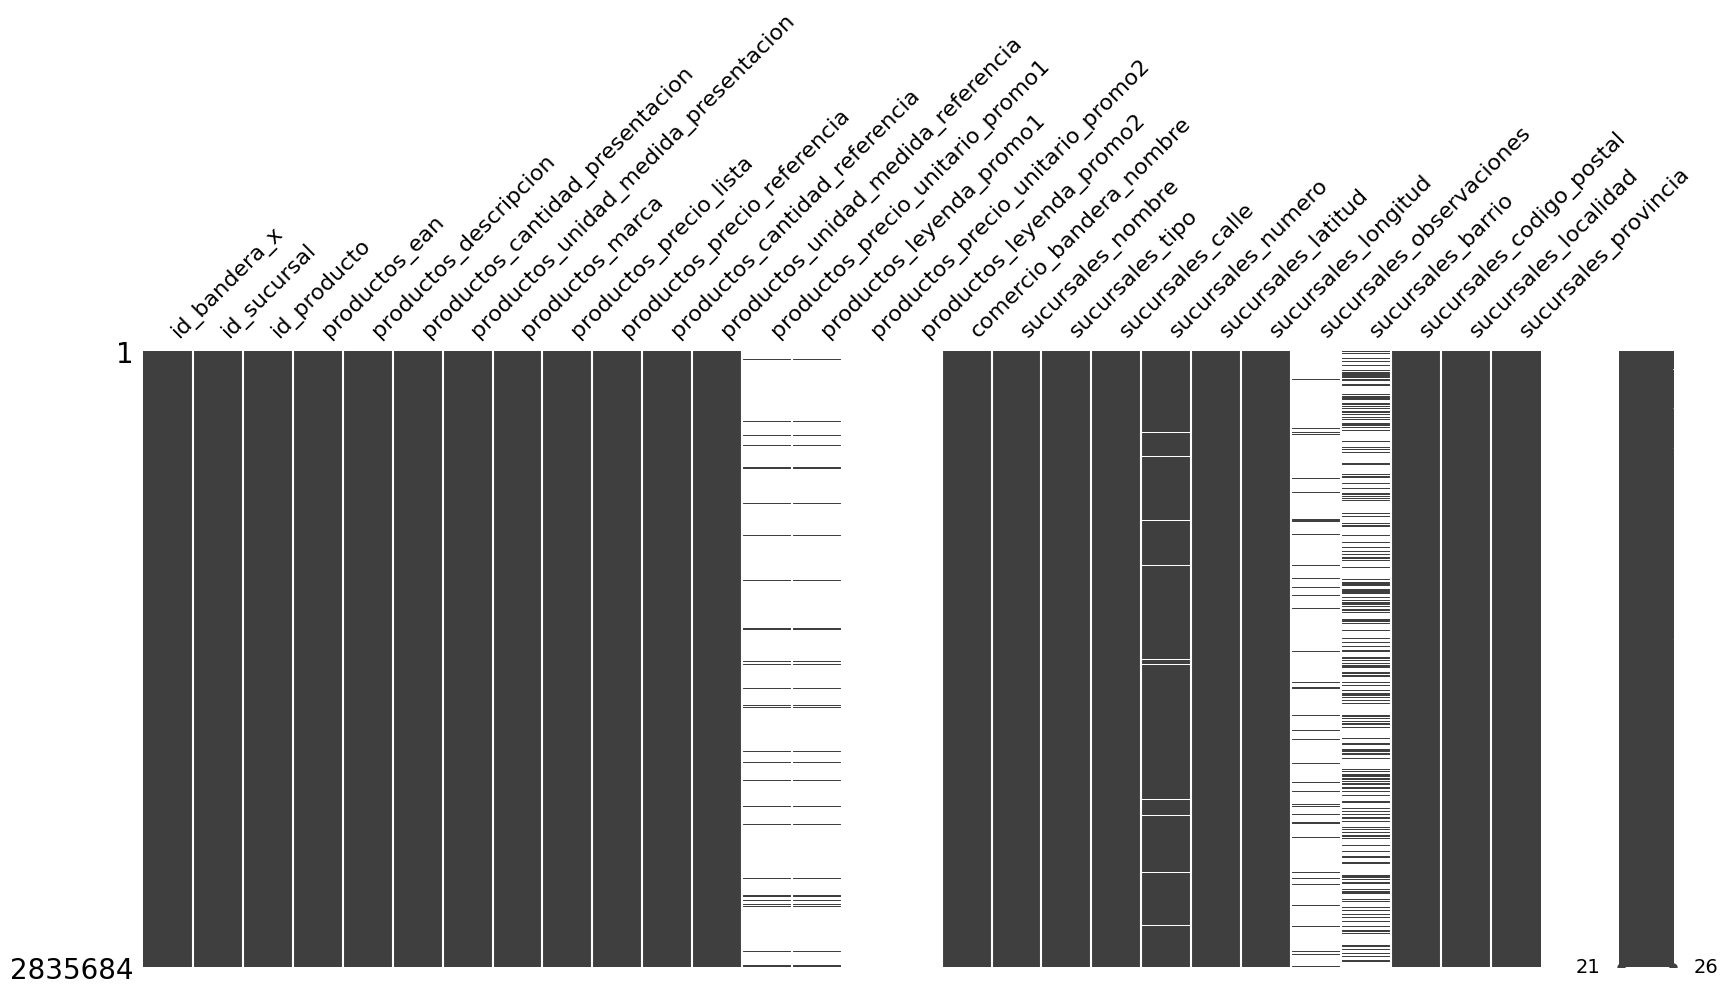

In [664]:
msno.matrix(datos, figsize=(20,8))


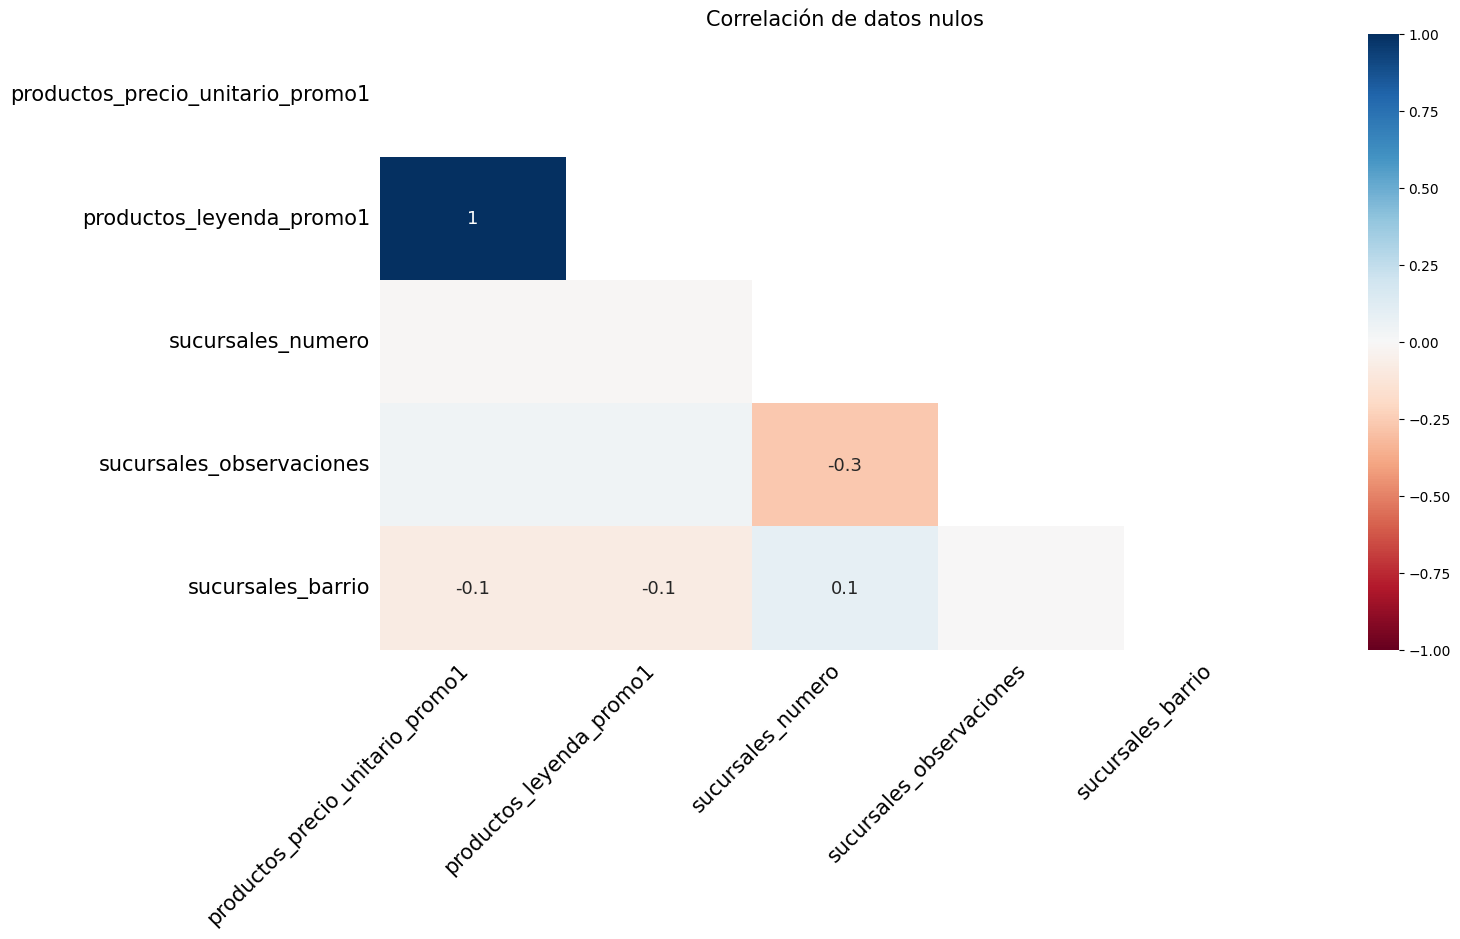

In [665]:
msno.heatmap(datos, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()


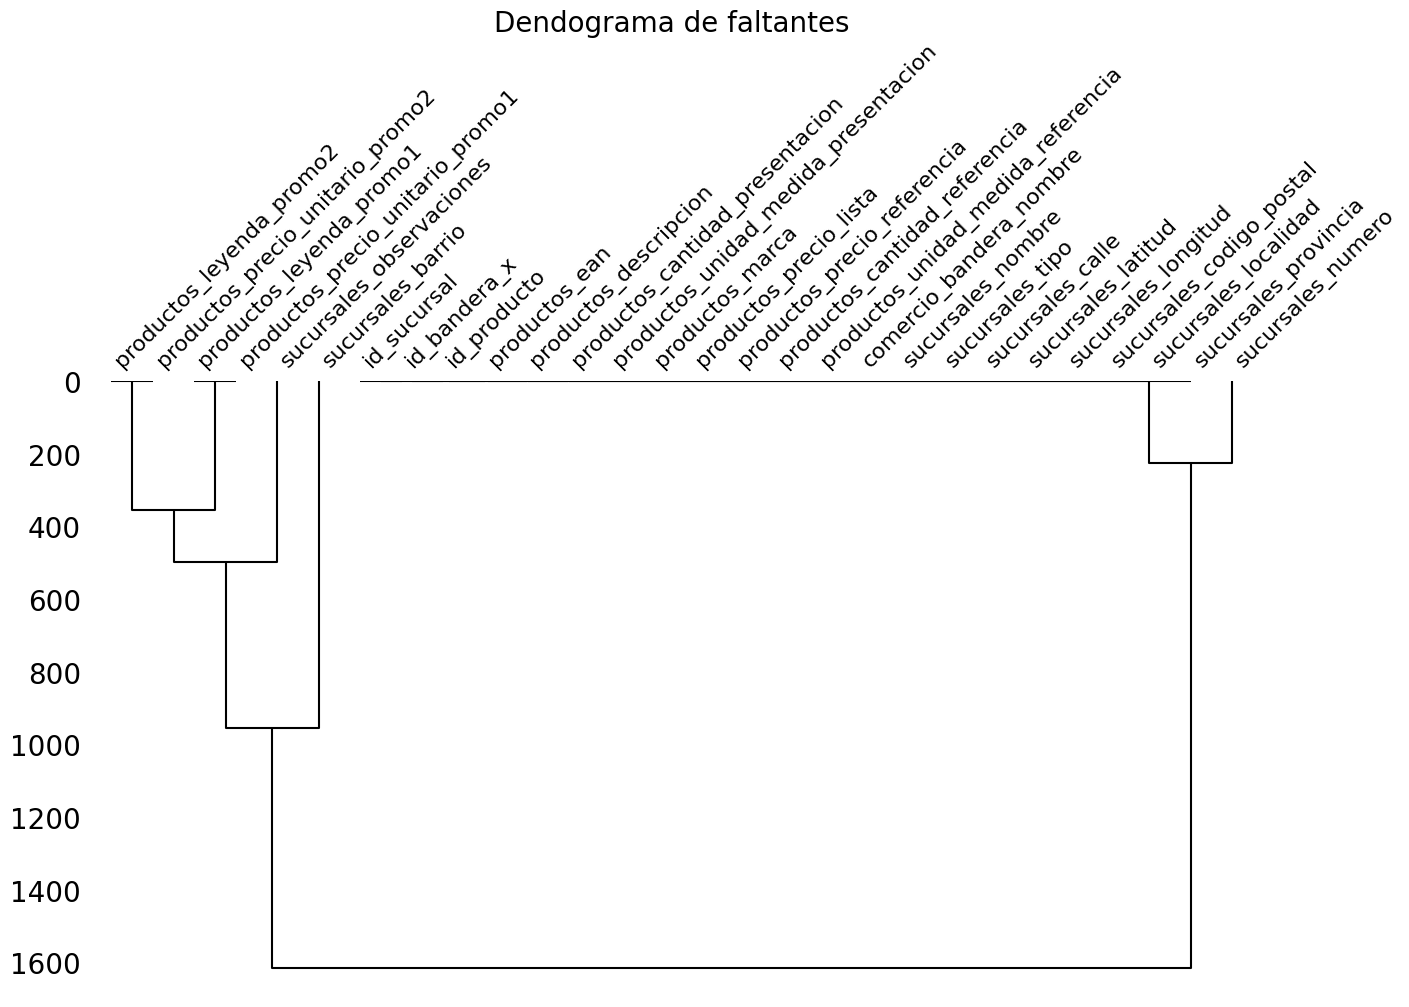

In [666]:
msno.dendrogram(datos, figsize=(15,8))
plt.title("Dendograma de faltantes", fontsize=20)
plt.show()



### Analisis de faltantes

Faltantes:

- Porcentaje de faltantes en productos_precio_unitario_promo1: 95.55%
- Porcentaje de faltantes en productos_leyenda_promo1: 95.55%
- Porcentaje de faltantes en productos_precio_unitario_promo2: 100.00%
- Porcentaje de faltantes en productos_leyenda_promo2: 100.00%
- Porcentaje de faltantes en sucursales_numero: 1.78%
- Porcentaje de faltantes en sucursales_observaciones: 92.85%
- Porcentaje de faltantes en sucursales_barrio 69.74%


#### *_promo2

Veamos que pasa con `productos_precio_unitario_promo2` y `productos_leyenda_promo2`. 
En el PDF que adjunta este dataset lo describe a la promosion de tipo 2 como, una promosión especial; mientras que a la promoción 1 (`productos_precio_unitario_promo1` y `productos_leyenda_promo1`) la llama general. La clave para poder distingir la promoción de tipo y y la promición de tipo 2 es que:
- La promoción de tipo 1 no contempla segmentación de consumidor (Jubilado, Estudiante, etc), mientras que la de tipo 2 si.
- La promoción de tipo 1 no comtempla medios de pago o tarjeta de fidelizacion, mientras que la de tipo 2 si.

Podemos concluir que (MNAR) la falta del dato depende de del dato en sí mismo, no es tan descabellado asumir que no se registraron promosiones de este tipo para los productos.

#### *_promo1

`productos_precio_unitario_promo1` y `productos_leyenda_promo1` estan relacionadas, lo podemos ver en la matriz de corelacion. Los valores existentes responden a promos generales.

In [667]:
# Creamos una función para calcular el porcentaje de nulos en una columna, agrupando por una o más columnas
def nulos_por_grupo(df, grupo_cols, target_col):
    agrupar_nulos = (
        df.groupby(grupo_cols, observed=True)[target_col]
        .apply(lambda x: x.isnull().mean() * 100)
        .reset_index(name=f'porcentaje_nulos_{target_col}')
    )
    return agrupar_nulos

In [668]:
print(datos[~datos['productos_leyenda_promo1'].isna()][['productos_descripcion', 'productos_leyenda_promo1', 'productos_marca']])


                                     productos_descripcion  \
9               POCHOCLO DULCE MICROONDAS POPCORN X 87 GRS   
11                    QUESO AZUL BAVARIA TROZADO X 125 GRS   
74             TABLETA CHOCOLATE BLANCO KIT KAT X 41.5 GRS   
111                         MAMADERA SILICONA 140 ML FR 6M   
120                      ROLLO PAPEL MANTECA BULNEZ X4 MTS   
...                                                    ...   
2835637                    DIFUSOR SPIRIT FUME X400 JAZMIN   
2835643  YOGURT PLANT B COLC MANG MARA FELICS L VACAS X...   
2835657            BATIDORA DE MANO MANDINE NEG MHM400 24L   
2835676            COCINA ELECTRICA ATMA INOX 60CM CCV060X   
2835679     SET TENEDORES X 3 CAROL NEGRO FUSION TI 12 EXP   

                                  productos_leyenda_promo1    productos_marca  
9        Promo A valida desde el 08/07/2025 hasta 14/07...            MARLOMS  
11       Promo A valida desde el 08/07/2025 hasta 14/07...                S/D  
74       Promo 

In [669]:
# Veamos que pasa con `sucursales_numero` y `sucursales_observaciones`

# Obtenemos las filas que tienen algún problema.
problematic_rows = datos[datos['sucursales_numero'].isna()]

# Como tenemos los datos de-normalizados por producto, removemos los duplicados para poder quedarnos solo con las sucursales que tienen problemas
problematic_rows.drop_duplicates(subset=['sucursales_latitud', 'sucursales_longitud'], keep='first', inplace=False)[['sucursales_numero', 'sucursales_calle', 'sucursales_observaciones', 'sucursales_localidad']]


sucursales_numero          sucursales_calle sucursales_observaciones  \
2                  NaN                Av. Ávalos                y Lavalle   
3                  NaN  Panamericana Ramal Pilar                    Km 54   
33                 NaN   Av. Gaona y Graham Bell                      NaN   
187                NaN            Av. Díaz Vélez          Esquina Medrano   

                sucursales_localidad  
2                        Resistencia  
3                              Pilar  
33                            Moreno  
187  Ciudad Autónoma de Buenos Aires

#### sucursales_numero

Hay alguna correlacion entre estos datos, podemos observar en la matriz de correlacion que tiene un valor numerico de relacion positivo, pero bajo.
- Para la fila 2, podemos observar que la interesección de la calle está en `sucursales_observaciones`.
- Para la fila 3, podemos observar que el kilometro en el que se encuentra la sucursal está en `sucursales_observaciones`.
- Para la fila 33, podemos observar que en `sucrusales_calle` se encuentra la intersección en la que está la sucursal.
- Para la fila 187, podemos observar que la interesección de la calle está en `sucursales_observaciones`.

No hay una cantidad de datos faltantes significativa, aún asi, tal vez deberíamos usar directamente la geolocalización.

In [670]:
# sucursales_barrio
deduped = datos.drop_duplicates(subset=['sucursales_latitud', 'sucursales_longitud'], keep='first', inplace=False)

nulos_barrio_por_localidad = nulos_por_grupo(deduped, 'sucursales_localidad', 'sucursales_barrio')
# removemos los faltantes para poder visualizar mejor
nulos_barrio_por_localidad = nulos_barrio_por_localidad[nulos_barrio_por_localidad['porcentaje_nulos_sucursales_barrio'] < 100]
nulos_barrio_por_provincia = nulos_por_grupo(deduped, 'sucursales_provincia', 'sucursales_barrio')

print("Nulos en 'barrio' por provincia:\n", nulos_barrio_por_provincia, "\n")
print("Nulos en 'barrio' por localidad:\n", nulos_barrio_por_localidad, "\n")


Nulos en 'barrio' por provincia:
    sucursales_provincia  porcentaje_nulos_sucursales_barrio
0                  AR-A                          100.000000
1                  AR-B                           83.333333
2                  AR-C                           20.795107
3                  AR-D                          100.000000
4                  AR-E                           30.000000
5                  AR-F                            0.000000
6                  AR-H                          100.000000
7                  AR-J                          100.000000
8                  AR-K                          100.000000
9                  AR-L                           50.000000
10                 AR-M                          100.000000
11                 AR-P                          100.000000
12                 AR-Q                          100.000000
13                 AR-R                          100.000000
14                 AR-S                          100.000000
15    

/var/folders/wl/620f1rg12p3bsd3m41yfv7y40000gn/T/ipykernel_29640/3576189948.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


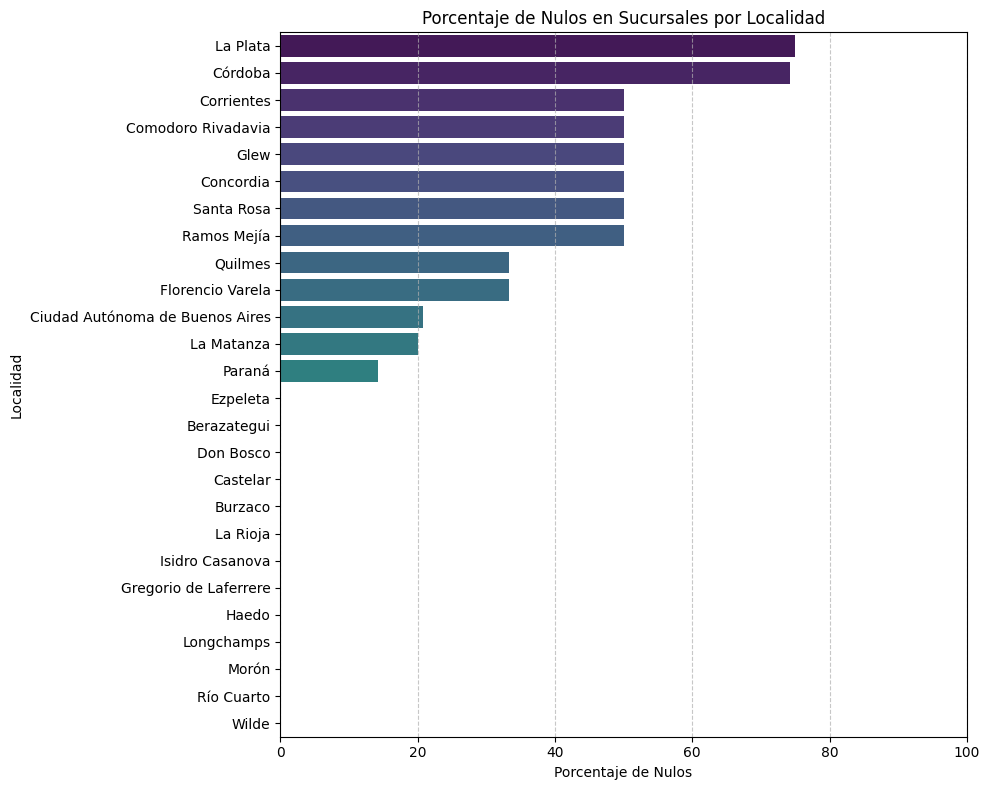

In [671]:

ordenados = nulos_barrio_por_localidad.sort_values(by='porcentaje_nulos_sucursales_barrio', ascending=False)

lista_orden = nulos_barrio_por_localidad.sort_values(by='porcentaje_nulos_sucursales_barrio', ascending=False)['sucursales_localidad'].tolist()

plt.figure(figsize=(10, 8)) 
sns.barplot(
    x='porcentaje_nulos_sucursales_barrio',
    y='sucursales_localidad',
    data=nulos_barrio_por_localidad,
    order=lista_orden,
    palette='viridis' 
)

plt.title('Porcentaje de Nulos en Sucursales por Localidad')
plt.xlabel('Porcentaje de Nulos')
plt.ylabel('Localidad')
plt.xlim(0, 100) 
plt.grid(axis='x', linestyle='--', alpha=0.7) 

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

Una hipotesis puede ser que solo las ciudades con muchas sucursales tienen el barrio asignado, pero como vemos el caso de Rosario que tiene 5 sucursales, no estan disponibles. Por lo tanto podemos concluir que es MNAR: la falta del dato depende de del dato en sí mismo.

## Detección de outliers

### Métodos estadísticos para detectar outliers
#### Basado en el rango intercuartil

Un dato se considera outlier si es < (Q1 - 1.5 * IQR)) o > (Q3 + 1.5 * IQR)

In [672]:
# Métodos estadísticos para detectar outliers
datos_a_detectar_outliers = datos[['productos_precio_lista', 'productos_precio_unitario_promo1']]

Q1 = datos_a_detectar_outliers.quantile(0.25)
Q3 = datos_a_detectar_outliers.quantile(0.75)

IQR = Q3 - Q1
outliers_iqr = (datos_a_detectar_outliers < (Q1 - 1.5 * IQR)) | (datos_a_detectar_outliers > (Q3 + 1.5 * IQR))

print("Outliers")
print(f"productos_precio_lista: <{Q1['productos_precio_lista'] - 1.5 * IQR['productos_precio_lista']:.02f} o >{Q3['productos_precio_lista'] + 1.5 * IQR['productos_precio_lista']:.02f}")
print(f"productos_precio_unitario_promo1: <{Q1['productos_precio_unitario_promo1'] - 1.5 * IQR['productos_precio_unitario_promo1']:.02f} o >{Q3['productos_precio_unitario_promo1'] + 1.5 * IQR['productos_precio_unitario_promo1']:.02f}")

Outliers
productos_precio_lista: <-5662.50 o >14261.50
productos_precio_unitario_promo1: <-66932.81 o >120159.69


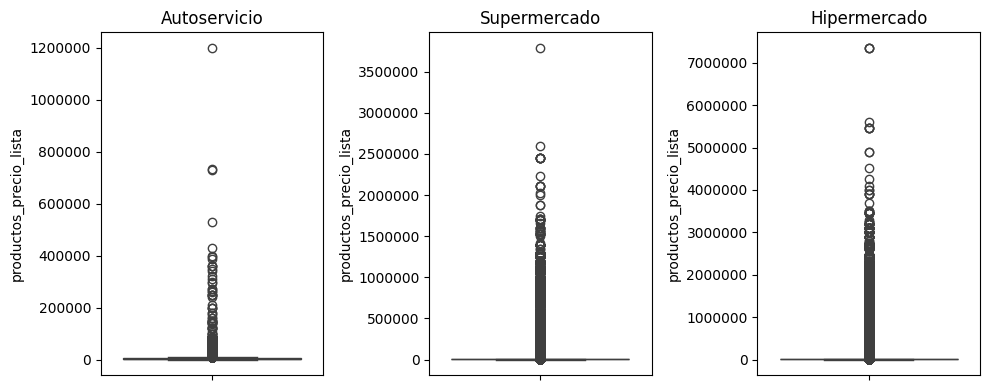

In [673]:
# BOX PLOT PARA productos_precio_lista

# Visualización de outliers con boxplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Boxplot para 'productos_precio_lista' (Autoservicios)
sns.boxplot(y=datos[datos['sucursales_tipo'] == 'Autoservicio']['productos_precio_lista'], ax=axes[0])
axes[0].set_title('Autoservicio')
axes[0].get_yaxis().get_major_formatter().set_scientific(False) 

# Boxplot para 'productos_precio_lista' (Supermercados)
sns.boxplot(y=datos[datos['sucursales_tipo'] == 'Supermercado']['productos_precio_lista'], ax=axes[1])
axes[1].set_title('Supermercado')
axes[1].get_yaxis().get_major_formatter().set_scientific(False) 

# Boxplot para 'productos_precio_lista' (Hipermercado)
sns.boxplot(y=datos[datos['sucursales_tipo'] == 'Hipermercado']['productos_precio_lista'], ax=axes[2])
axes[2].set_title('Hipermercado')
axes[2].get_yaxis().get_major_formatter().set_scientific(False) 

plt.tight_layout()
plt.show()


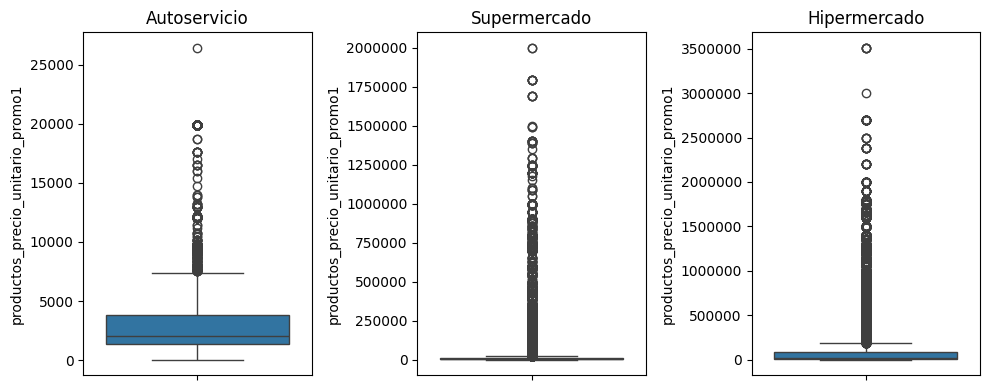

In [674]:
# BOX PLOT PARA productos_precio_unitario_promo1

# Visualización de outliers con boxplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Boxplot para 'productos_precio_lista' (Autoservicios)
sns.boxplot(y=datos[datos['sucursales_tipo'] == 'Autoservicio']['productos_precio_unitario_promo1'], ax=axes[0])
axes[0].set_title('Autoservicio')
axes[0].get_yaxis().get_major_formatter().set_scientific(False) 

# Boxplot para 'productos_precio_lista' (Supermercados)
sns.boxplot(y=datos[datos['sucursales_tipo'] == 'Supermercado']['productos_precio_unitario_promo1'], ax=axes[1])
axes[1].set_title('Supermercado')
axes[1].get_yaxis().get_major_formatter().set_scientific(False) 

# Boxplot para 'productos_precio_lista' (Hipermercado)
sns.boxplot(y=datos[datos['sucursales_tipo'] == 'Hipermercado']['productos_precio_unitario_promo1'], ax=axes[2])
axes[2].set_title('Hipermercado')
axes[2].get_yaxis().get_major_formatter().set_scientific(False) 

plt.tight_layout()
plt.show()


### Basado en la desviación estándar (distribución normal)

Un dato se considera outlier si es < (mean - 3 * std) o > (mean + 3 * std)


In [675]:
# Método basado en desviación estándar
datos_a_detectar_outliers = datos[['productos_precio_lista', 'productos_precio_unitario_promo1']]

mean = datos_a_detectar_outliers.mean()
#std = df.std()
std = datos_a_detectar_outliers.apply(lambda x: np.nanstd(x, ddof=1))

outliers_std = (datos_a_detectar_outliers < (mean - 3 * std)) | (datos_a_detectar_outliers > (mean + 3 * std))

print(f"Outliers")
print(f"Precio lista: <{mean['productos_precio_lista'] - 3 * std['productos_precio_lista']:.02f} o >{mean['productos_precio_lista'] + 3 * std['productos_precio_lista']:.02f}")
print(f"Precio Promo1: <{mean['productos_precio_unitario_promo1'] - 3 * std['productos_precio_unitario_promo1']:.02f} o >{mean['productos_precio_unitario_promo1'] + 3 * std['productos_precio_unitario_promo1']:.02f}")

Outliers
Precio lista: <-226188.49 o >253758.27
Precio Promo1: <-590023.88 o >774370.17


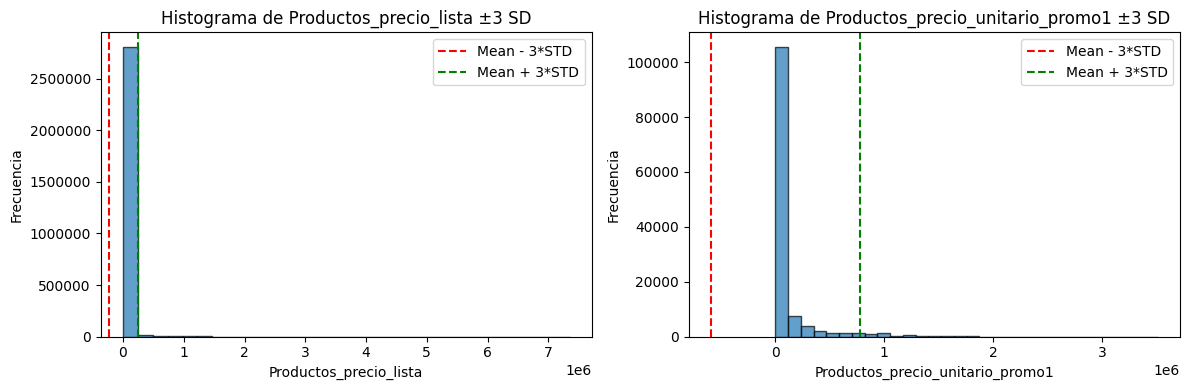

In [676]:
def plot_hist_with_std(ax, data, varname, mean, std):
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(mean[varname] - 3*std[varname], color='red', linestyle='--', label='Mean - 3*STD')
    ax.axvline(mean[varname] + 3*std[varname], color='green', linestyle='--', label='Mean + 3*STD')
    ax.set_xlabel(varname.capitalize())
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Histograma de {varname.capitalize()} ±3 SD')
    ax.get_yaxis().get_major_formatter().set_scientific(False) 

    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_hist_with_std(ax[0], datos_a_detectar_outliers['productos_precio_lista'], 'productos_precio_lista', mean, std)
plot_hist_with_std(ax[1], datos_a_detectar_outliers['productos_precio_unitario_promo1'], 'productos_precio_unitario_promo1', mean, std)

plt.tight_layout()
plt.show()


/Users/jose/Code/PostgradoIAUBA/Analisis_de_datos/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


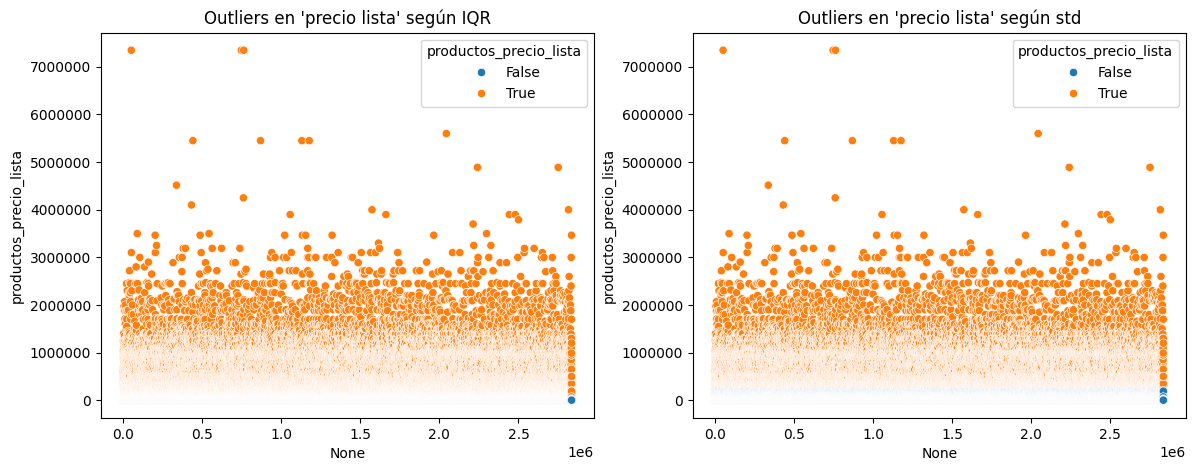

In [677]:
# Visualización con scatterplot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x=datos.index, y=datos['productos_precio_lista'], hue=outliers_iqr['productos_precio_lista'], ax=ax[0])
ax[0].set_title("Outliers en 'precio lista' según IQR")
ax[0].get_yaxis().get_major_formatter().set_scientific(False) 

sns.scatterplot(x=datos.index, y=datos['productos_precio_lista'], hue=outliers_std['productos_precio_lista'], ax=ax[1])
ax[1].set_title("Outliers en 'precio lista' según std")
ax[1].get_yaxis().get_major_formatter().set_scientific(False) 
plt.show()


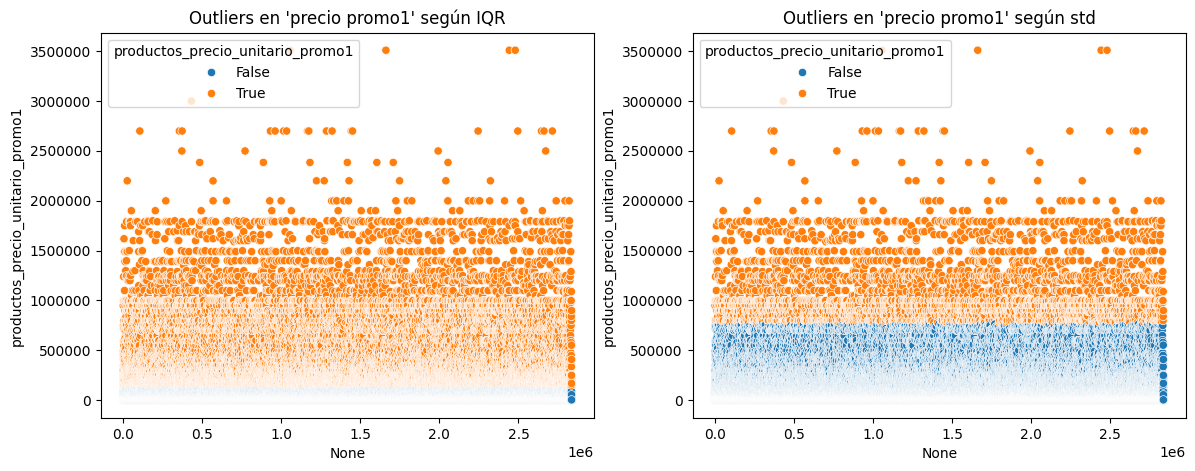

In [678]:
# Visualización con scatterplot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x=datos.index, y=datos['productos_precio_unitario_promo1'], hue=outliers_iqr['productos_precio_unitario_promo1'], ax=ax[0])
ax[0].set_title("Outliers en 'precio promo1' según IQR")
ax[0].get_yaxis().get_major_formatter().set_scientific(False) 

sns.scatterplot(x=datos.index, y=datos['productos_precio_unitario_promo1'], hue=outliers_std['productos_precio_unitario_promo1'], ax=ax[1])
ax[1].set_title("Outliers en 'precio promo1' según std")
ax[1].get_yaxis().get_major_formatter().set_scientific(False) 

plt.show()

### Exportación de dataset analizado

In [679]:
# MODIFICAR EL CODIGO PARA NUJESTR DATASET

import json

# Detectar columnas categóricas
categorical_cols = [col for col, dtype in datos.dtypes.items() if str(dtype) == 'category']

# Guardar los tipos como strings
dtypes_str = {col: str(dtype) for col, dtype in datos.dtypes.items()}

# Guardar todo en un solo JSON
info = {
    "dtypes": dtypes_str,
    "categoricals": categorical_cols
}

with open("dataset/carrefour_dtypes.json", "w") as f:
    json.dump(info, f)

# exportar CSV
datos.to_csv('dataset/carrefour.csv.gz', compression='gzip', sep='|', index=False)

---
## Conclusiones